# Lesson 8: Exercises

## Load CADETSettings

This imports all the standard libraries and provides some helper functions.

In [1]:
%run ../utils.ipynb

## Model templates

In [2]:
def create_reference_model():
    reference_model = create_dextran_model()
    
    reference_model.root.input.model.unit_001.adsorption_model = 'MULTI_COMPONENT_LANGMUIR'

    reference_model.root.input.model.unit_001.adsorption.is_kinetic = 1
    reference_model.root.input.model.unit_001.adsorption.mcl_ka = [1.144,]
    reference_model.root.input.model.unit_001.adsorption.mcl_kd = [2.0e-3,]
    reference_model.root.input.model.unit_001.adsorption.mcl_qmax = [4.88,]

    reference_model.root.input.model.unit_001.film_diffusion = [2.0E-7,]
    reference_model.root.input.model.unit_001.par_diffusion = [1e-8,]
    reference_model.root.input.model.unit_001.discretization.nbound = [1,]

    #solver settings
    reference_model.root.input.solver.sections.section_times = [0.0, 3000.0, 9500.0]

    #set the times that the simulator writes out data for
    reference_model.root.input.solver.user_solution_times = np.linspace(0, 9500, 9501)

    run_simulation(reference_model, 'langmuir_reference.h5')

## Exercise 1: 

Read experimental data from the `langmuir_experiment.csv` and try to determine the values for `mcl_ka`, `mcl_kd`, and `mcl_qmax`.

***Task:*** Compare the gradient approach with different starting values `match.seeds = [(ka, kd, qmax), ]`. 
Also try setting up the `NSGA3` optimizer.

***Hint:*** The `create_reference_model()` function also creates the necessary `.h5` file.

In [3]:
create_reference_model()

Simulation completed successfully


In [4]:
base_dir = Path('./').absolute()
match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results_exercise'

parameter1 = Dict()
parameter1.transform = 'auto'
parameter1.component = 0
parameter1.bound = 0
parameter1.location = '/input/model/unit_001/adsorption/MCL_KA'
parameter1.min = 1e-5
parameter1.max = 1e5

parameter2 = Dict()
parameter2.transform = 'auto'
parameter2.component = 0
parameter2.bound = 0
parameter2.location = '/input/model/unit_001/adsorption/MCL_KD'
parameter2.min = 1e-5
parameter2.max = 1e5

parameter3 = Dict()
parameter3.transform = 'auto'
parameter3.component = 0
parameter3.bound = 0
parameter3.location = '/input/model/unit_001/adsorption/MCL_QMAX'
parameter3.min = 1
parameter3.max = 20

match_config.parameters = [parameter1, parameter2, parameter3]

experiment1 = Dict()
experiment1.csv = 'resources/langmuir_experiment.csv'
experiment1.output_path = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'
experiment1.HDF5 = 'langmuir_reference.h5'
experiment1.name = 'main'

feature1 = Dict()
feature1.name = 'Pulse'
feature1.type = 'SSE'

experiment1.features = [feature1,]

match_config.experiments = [experiment1,]

match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

In [5]:
from CADETMatch.jupyter import Match

match_file = base_dir / 'langmuir.json'

with open(match_file, 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_file)
match.start_sim()

<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
/home/jo/software/miniconda3/envs/chromapy/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2021-10-26 12:16:24,281 match.py print_version 121 CADETMatch starting up version: 0.8.13

2021-10-26 12:16:24,298 match.py print_version 150 attrs version: 21.2.0 tested with 21.2.0

2021-10-26 12:16:24,299 match.py print_version 150 joblib version: 1.1.0 tested with 1.0.1

2021-10-26 12:16:24,300 match.py print_version 150 addict version: 2.4.0 tested with 2.4.0

2021-10-26 12:16:24,301 match.py print_version 150 corner version: 2.2.1 tested with 2.2.1

2021-10-26 12:16:24,301 match.py print_version 150 emcee version: 3.1.1 tested with 3.0.2

2021-10-26 12:16:24,302 match.py print_version 150 SALib version: 1.4.5 tested with 1.3.11

2021-10-26 12:16:24,304 match.py print_version 150 psutil version: 5.8.0 tested with 5.8.0

2021-10-26 12:16:24,304 match.py print_version 150 numpy version: 1.20.3 tested with 1.21.1

2021-10-26 12:16:24,305 match.py print_version 150 openpyxl version: 3.0.9 tested with 3.0.7

2021-10-26 12:16:24,306 match.py print_version 150 scipy version: 1.7.1 tested

Corner plot in search space


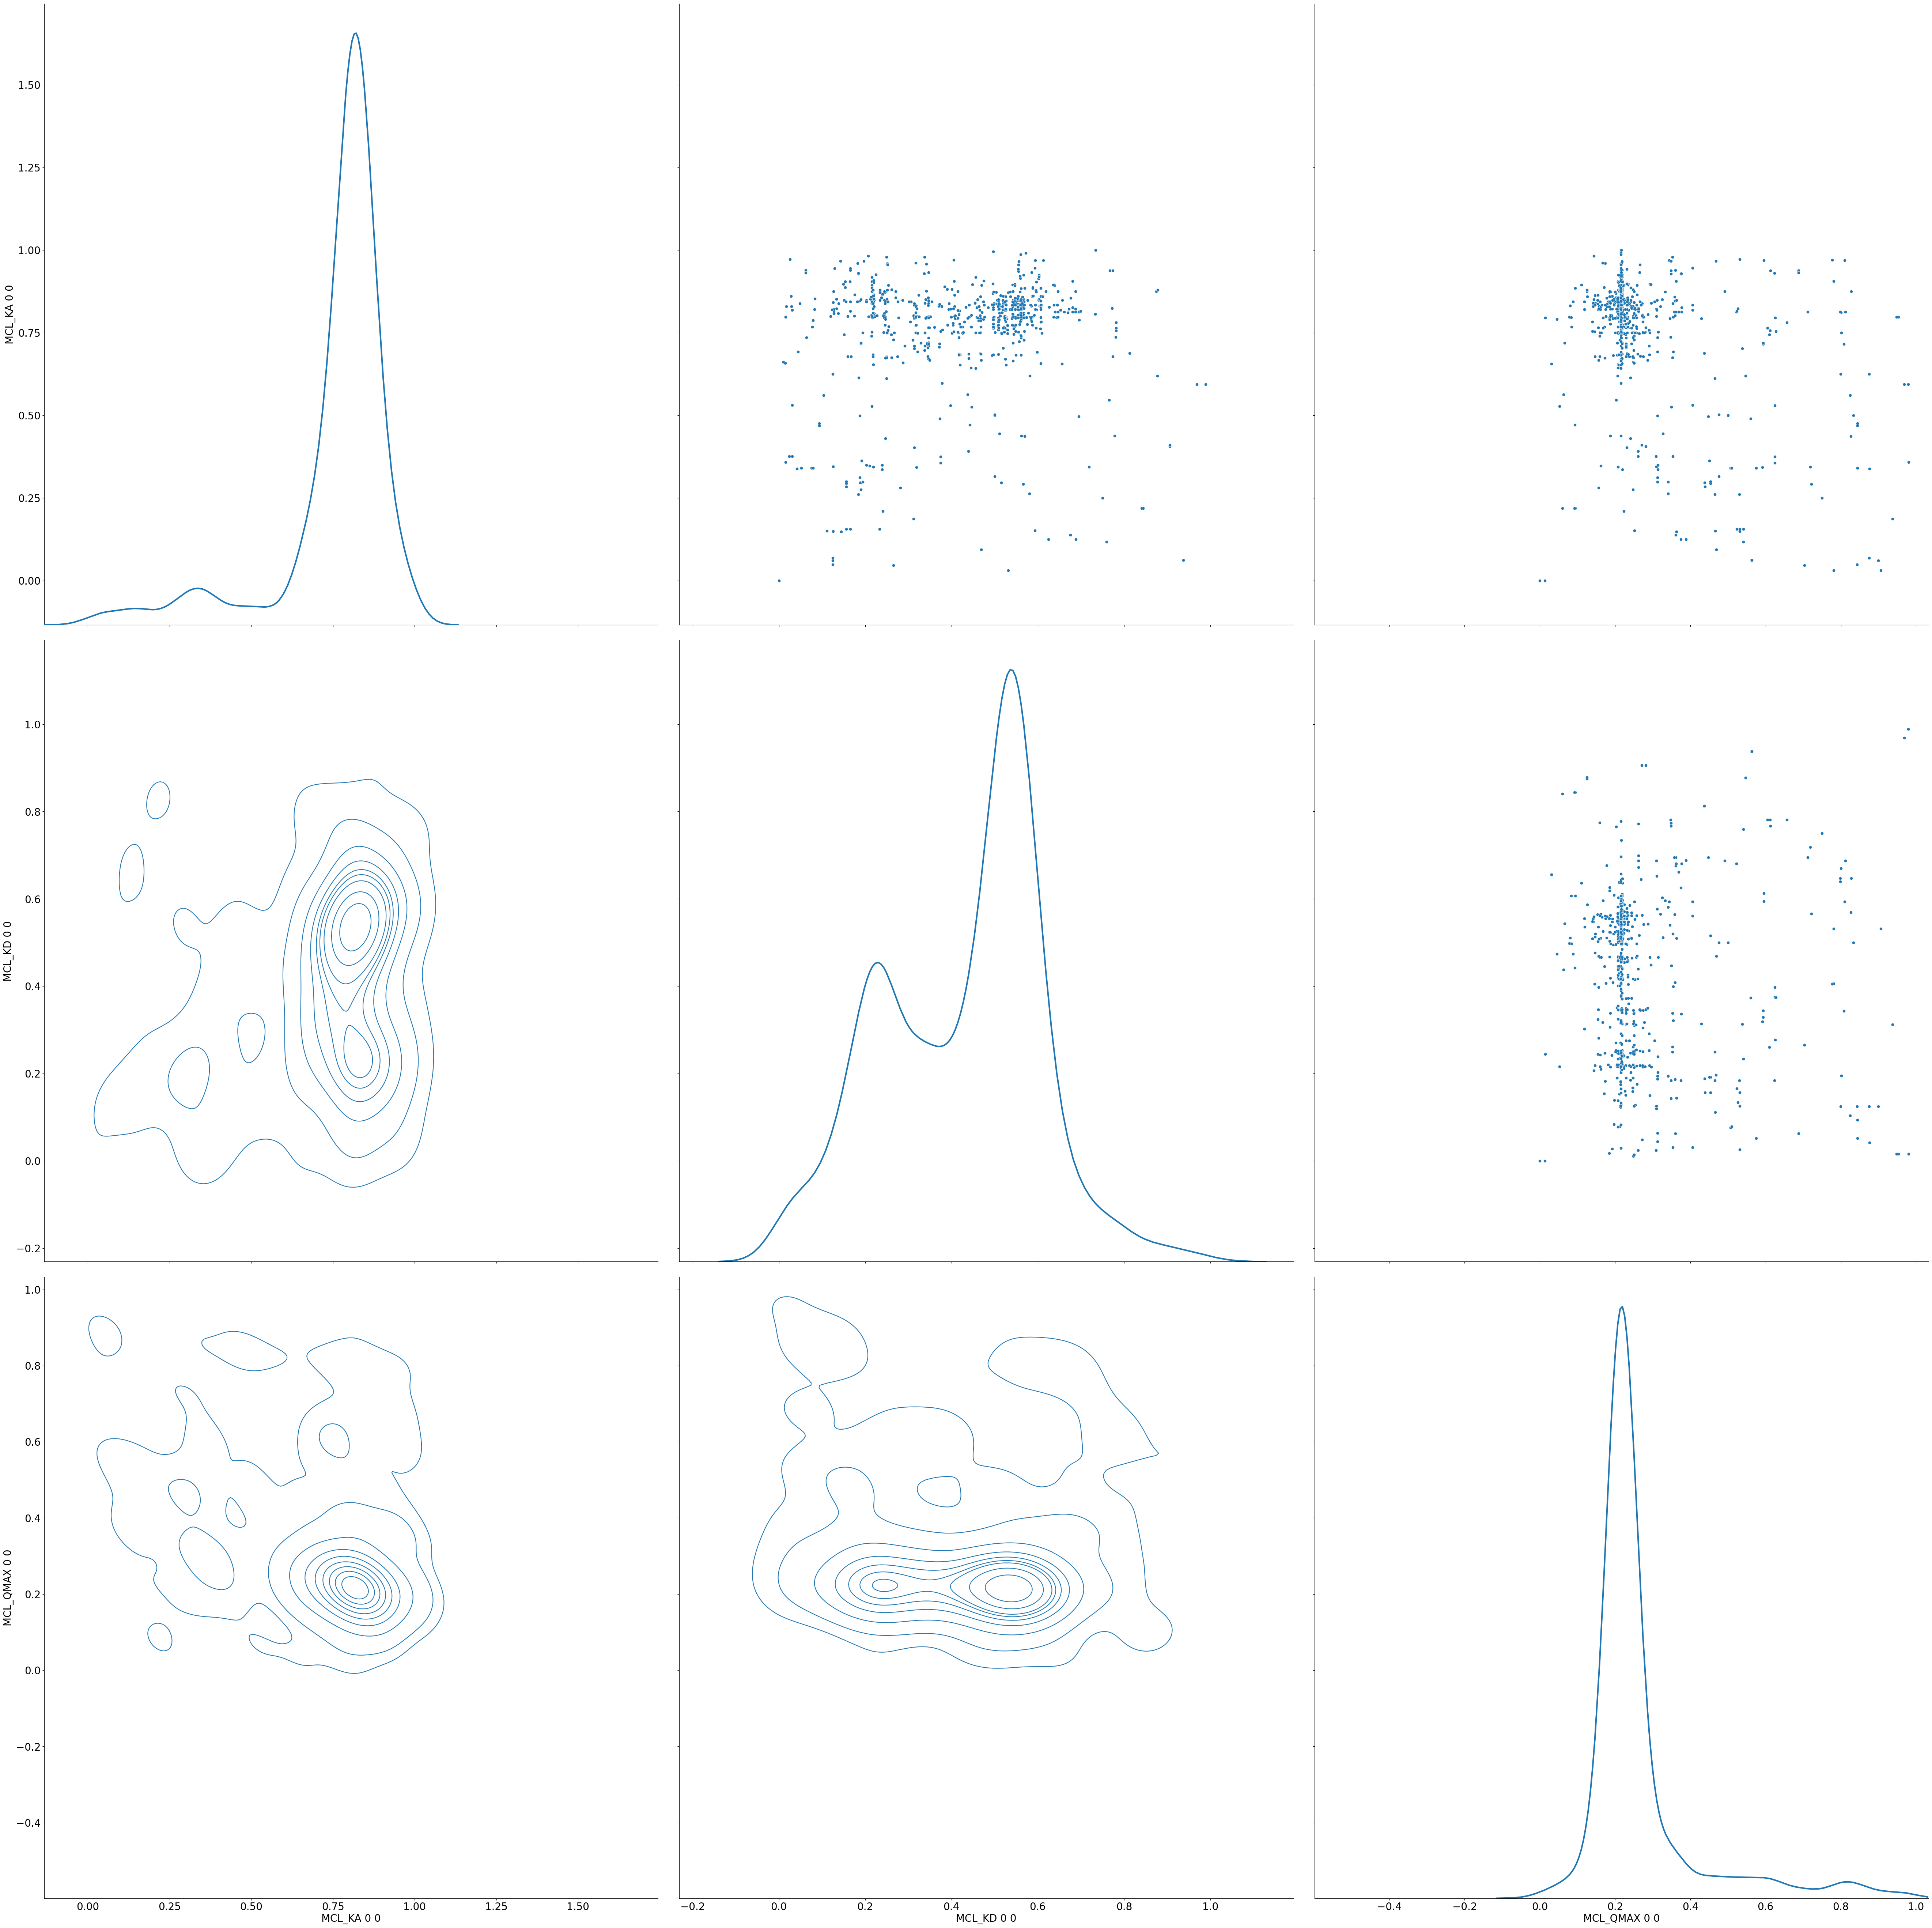

Corner plot in original space


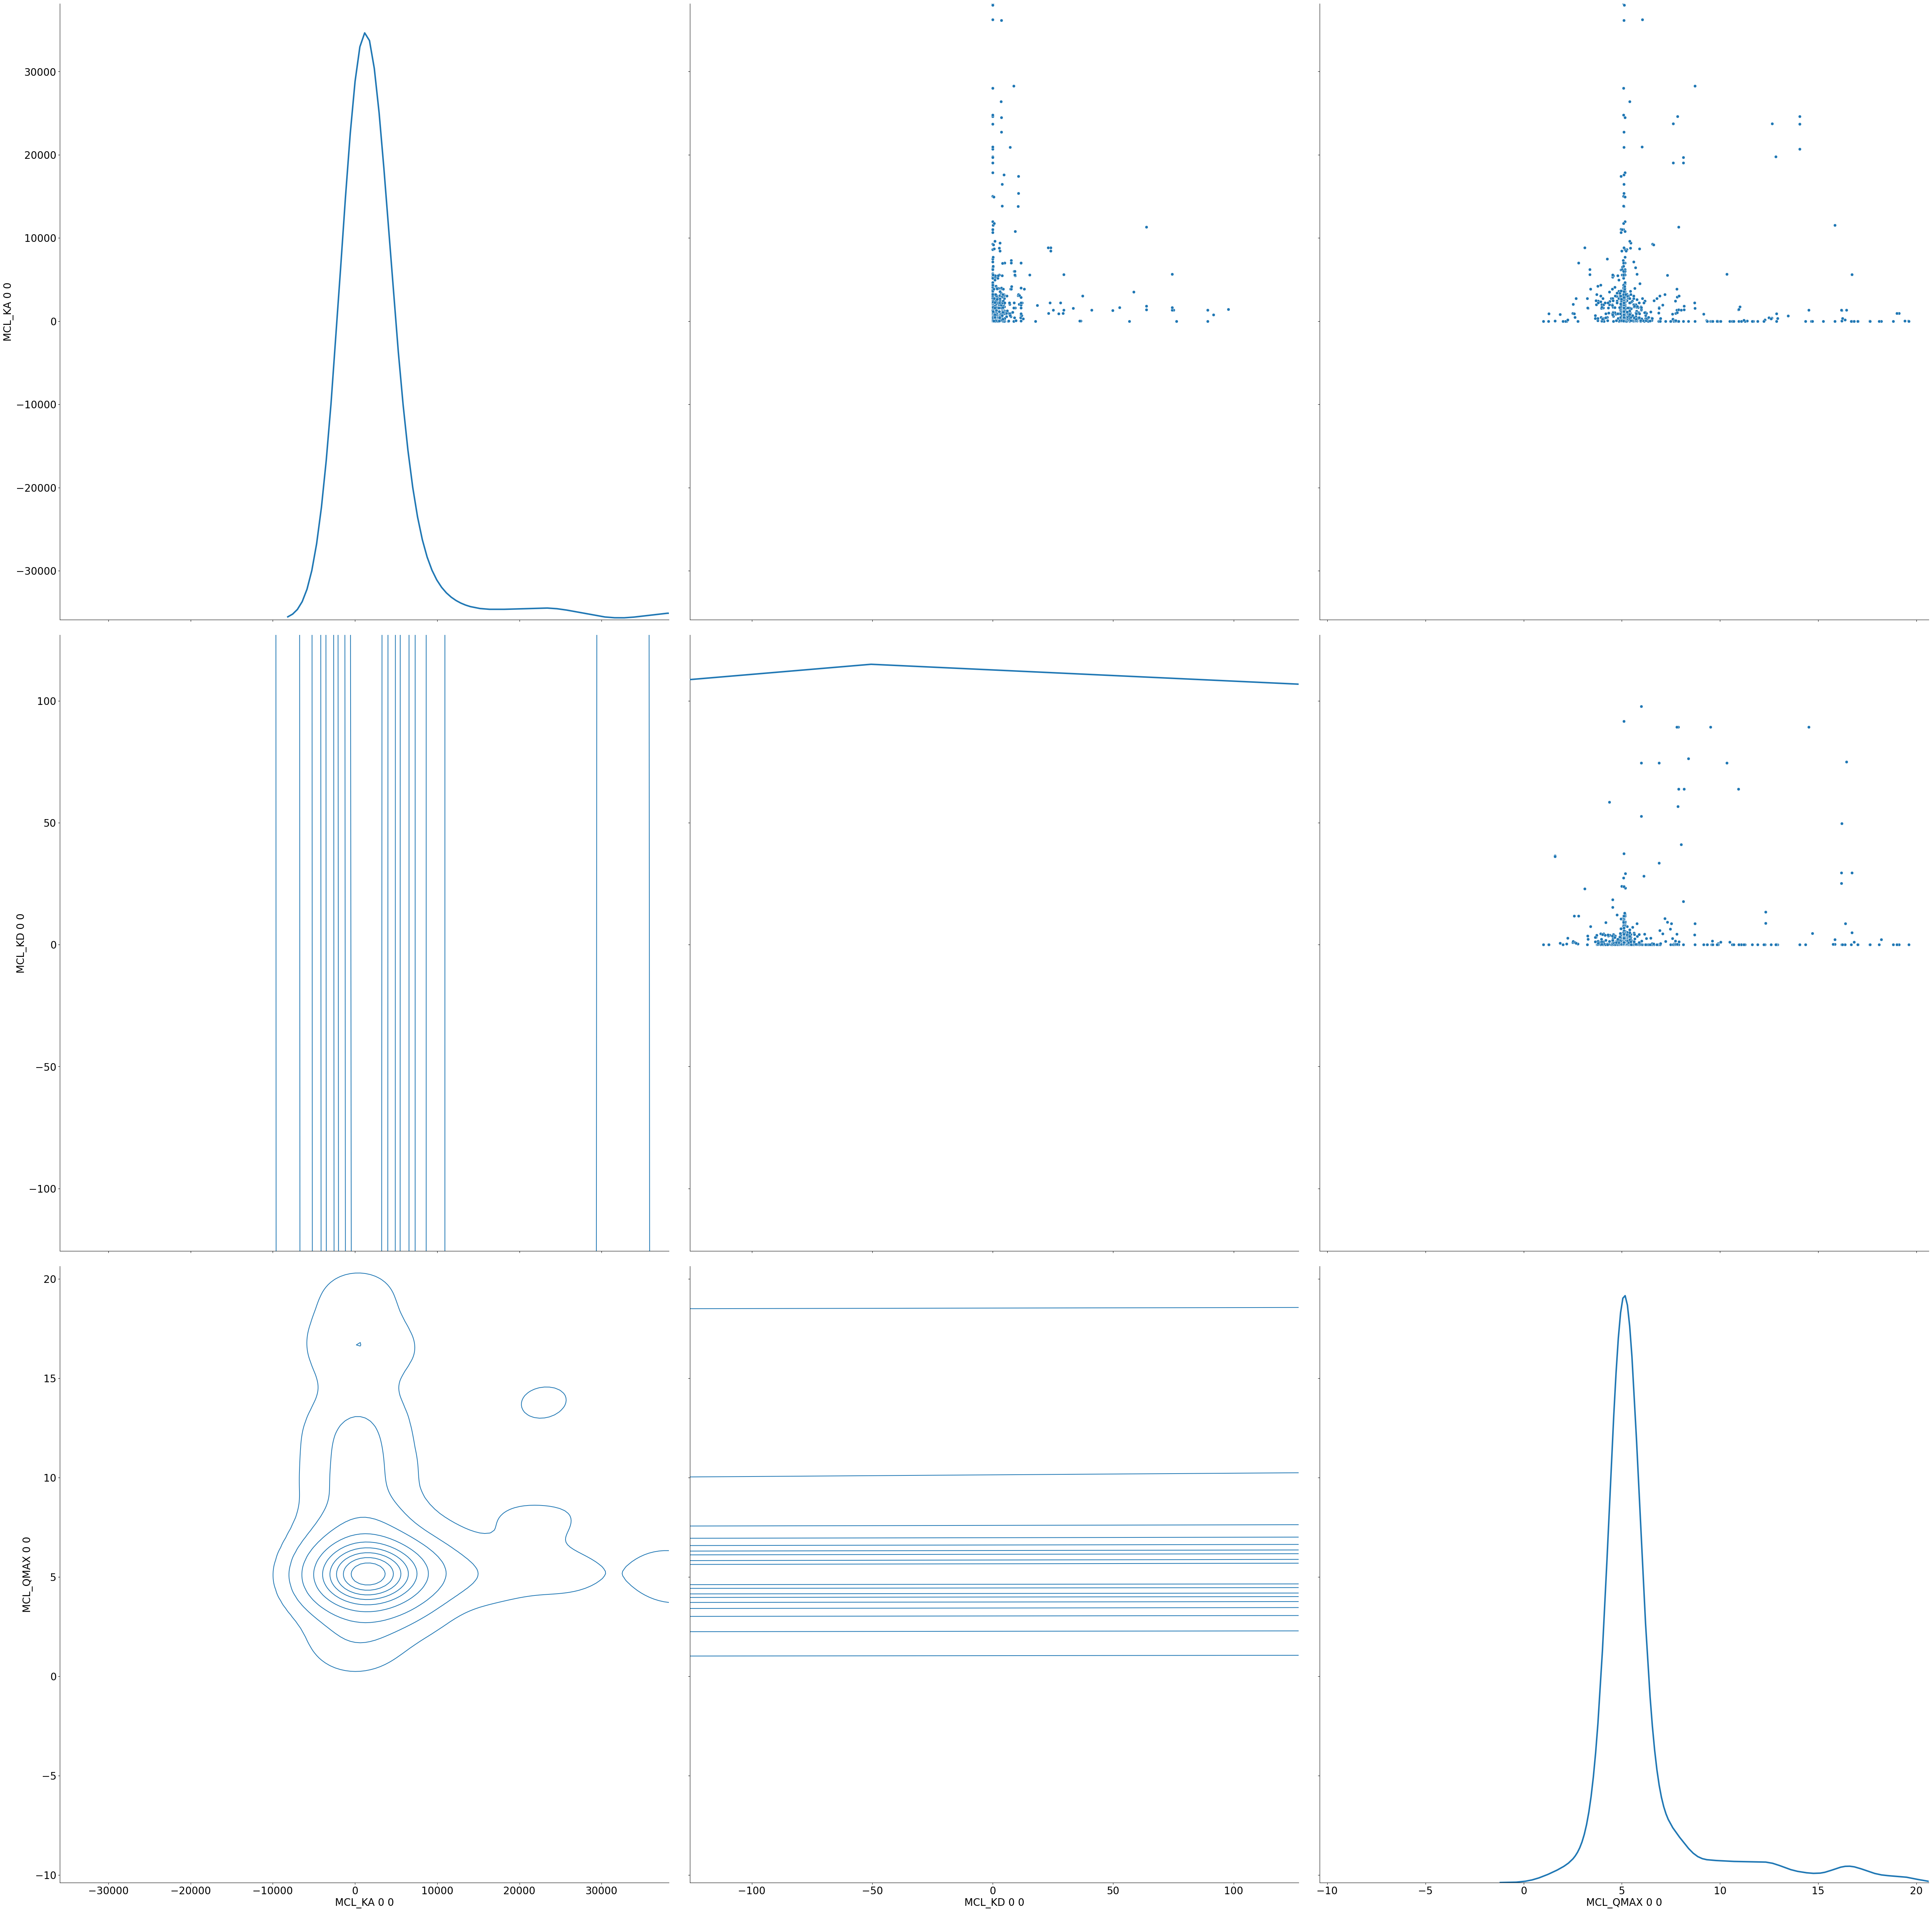

In [6]:
match.plot_corner()

Best item 30c9330954971c0525b984c766ae211b for meta score(s) Product Root Score , Min Score , Mean Score , SSE


Time                              Name Method  \
0  Tue Oct 26 12:21:35 2021  30c9330954971c0525b984c766ae211b   GRAD   

   Condition Number  MCL_KA Comp:0 Bound:0  MCL_KD Comp:0 Bound:0  \
0       4093.018005           99999.999974             217.924631   

   MCL_QMAX Comp:0 Bound:0  main_Pulse_SSE  Product Root Score  Min Score  \
0                 5.111472        0.665846            0.665846   0.665846   

   Mean Score       SSE      RMSE  
0    0.665846  0.665846  0.008371

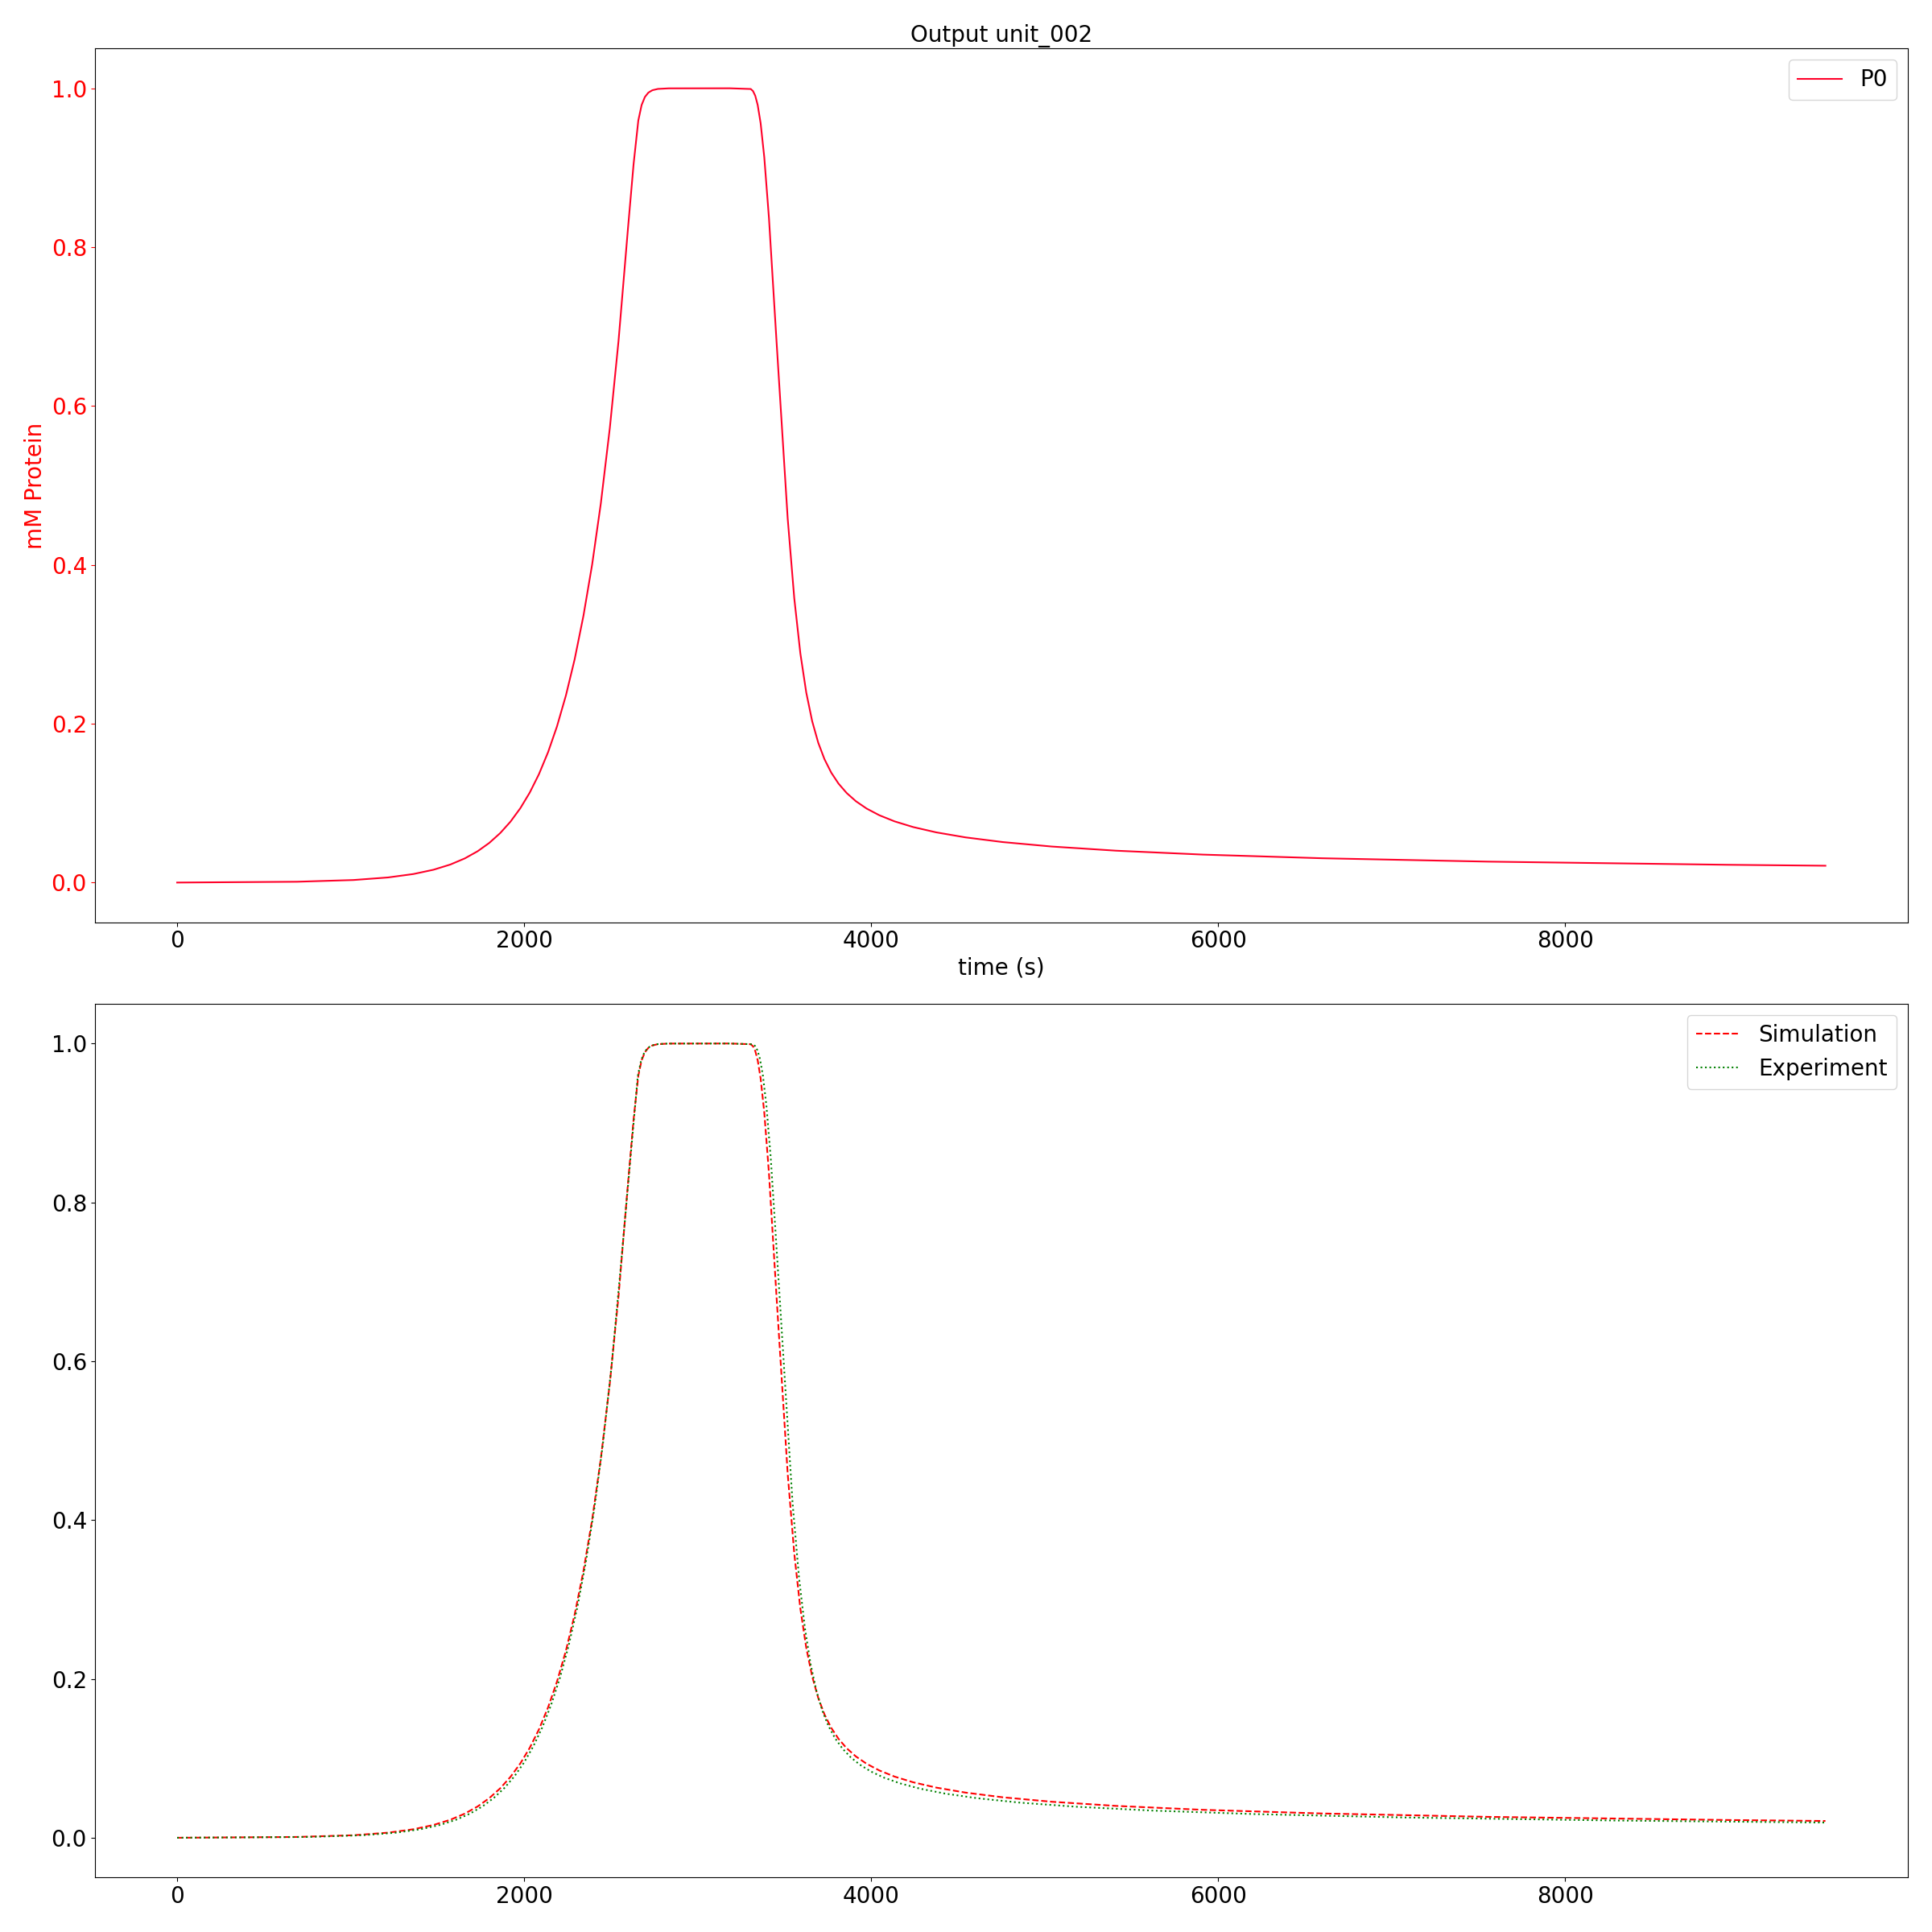

In [7]:
match.plot_best()

## Exercise 2: auto_keq 

For the same example, make use of the `auto_keq` parameter transform feature of `CADET-Match`.

***Hint:*** For this feature to work, you need to provide a list of locations for the corresponding `ka` and `kd` value of the selected isotherm.

In [8]:
base_dir = Path('./').absolute()
match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results_exercise_keq'

parameter1 = Dict()
parameter1.transform = 'auto_keq'
parameter1.component = 0
parameter1.bound = 0
parameter1.location = ['/input/model/unit_001/adsorption/MCL_KA', '/input/model/unit_001/adsorption/MCL_KD']
parameter1.minKA = 1e-5
parameter1.maxKA = 1e5
parameter1.minKEQ = 1e-4
parameter1.maxKEQ = 1e4

parameter2 = Dict()
parameter2.transform = 'auto'
parameter2.component = 0
parameter2.bound = 0
parameter2.location = '/input/model/unit_001/adsorption/MCL_QMAX'
parameter2.min = 1
parameter2.max = 20

match_config.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = 'resources/langmuir_experiment.csv'
experiment1.output_path = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'
experiment1.HDF5 = 'langmuir_reference.h5'
experiment1.name = 'main'

feature1 = Dict()
feature1.name = 'Pulse'
feature1.type = 'SSE'

experiment1.features = [feature1,]

match_config.experiments = [experiment1,]


match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

In [9]:
from CADETMatch.jupyter import Match

match_file = base_dir / 'langmuir_keq.json'

with open(match_file, 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_file)
match.start_sim()

/home/jo/software/miniconda3/envs/chromapy/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2021-10-26 12:22:35,677 match.py print_version 121 CADETMatch starting up version: 0.8.13

2021-10-26 12:22:35,690 match.py print_version 150 attrs version: 21.2.0 tested with 21.2.0

2021-10-26 12:22:35,690 match.py print_version 150 joblib version: 1.1.0 tested with 1.0.1

2021-10-26 12:22:35,691 match.py print_version 150 addict version: 2.4.0 tested with 2.4.0

2021-10-26 12:22:35,691 match.py print_version 150 corner version: 2.2.1 tested with 2.2.1

2021-10-26 12:22:35,692 match.py print_version 150 emcee version: 3.1.1 tested with 3.0.2

2021-10-26 12:22:35,693 match.py print_version 150 SALib version: 1.4.5 tested with 1.3.11

2021-10-26 12:22:35,694 match.py print_version 150 psutil version: 5.8.0 tested with 5.8.0

2021-10-26 12:22:35,694 match.py print_version 150 numpy version: 1.20.3 tested with 1.21.1

2021-10-26 12:22:35,695 match.py print_version 150 openpyxl version: 3.0.9 tested with 3.0.7

2021-10-26 12:22:35,695 match.py print_version 150 scipy version: 1.7.1 tested

Corner plot in search space


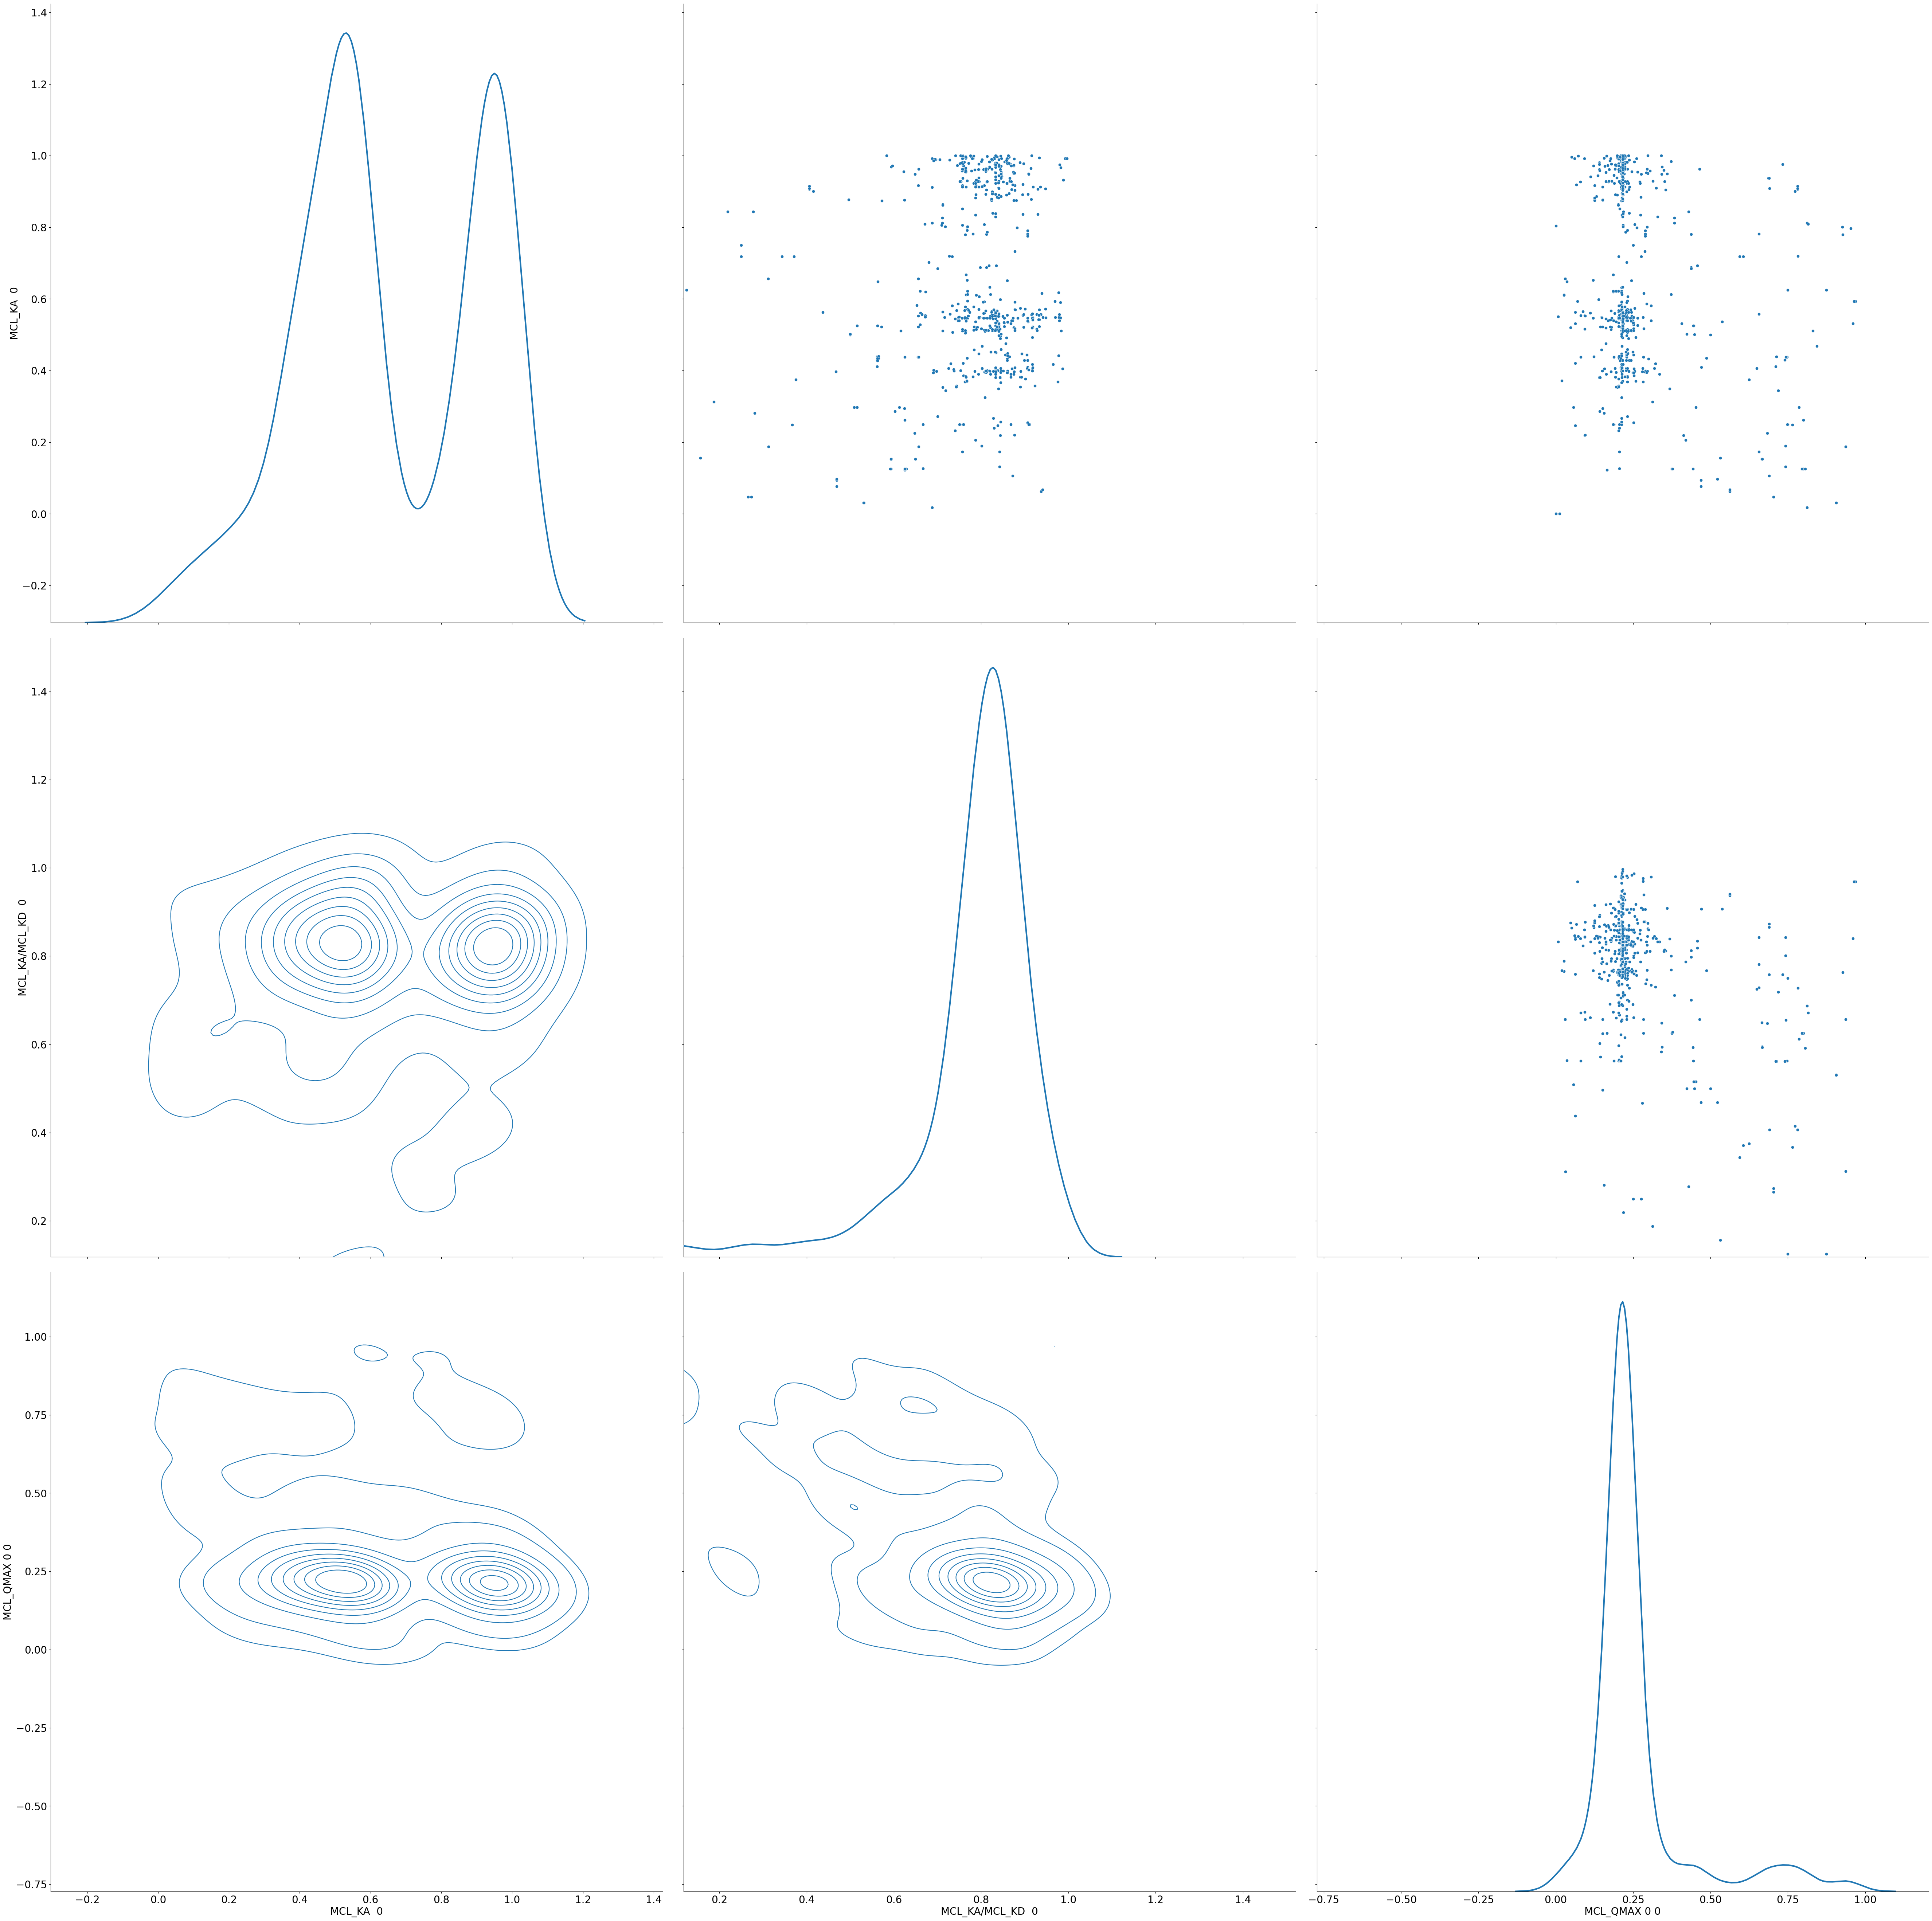

Corner plot in original space


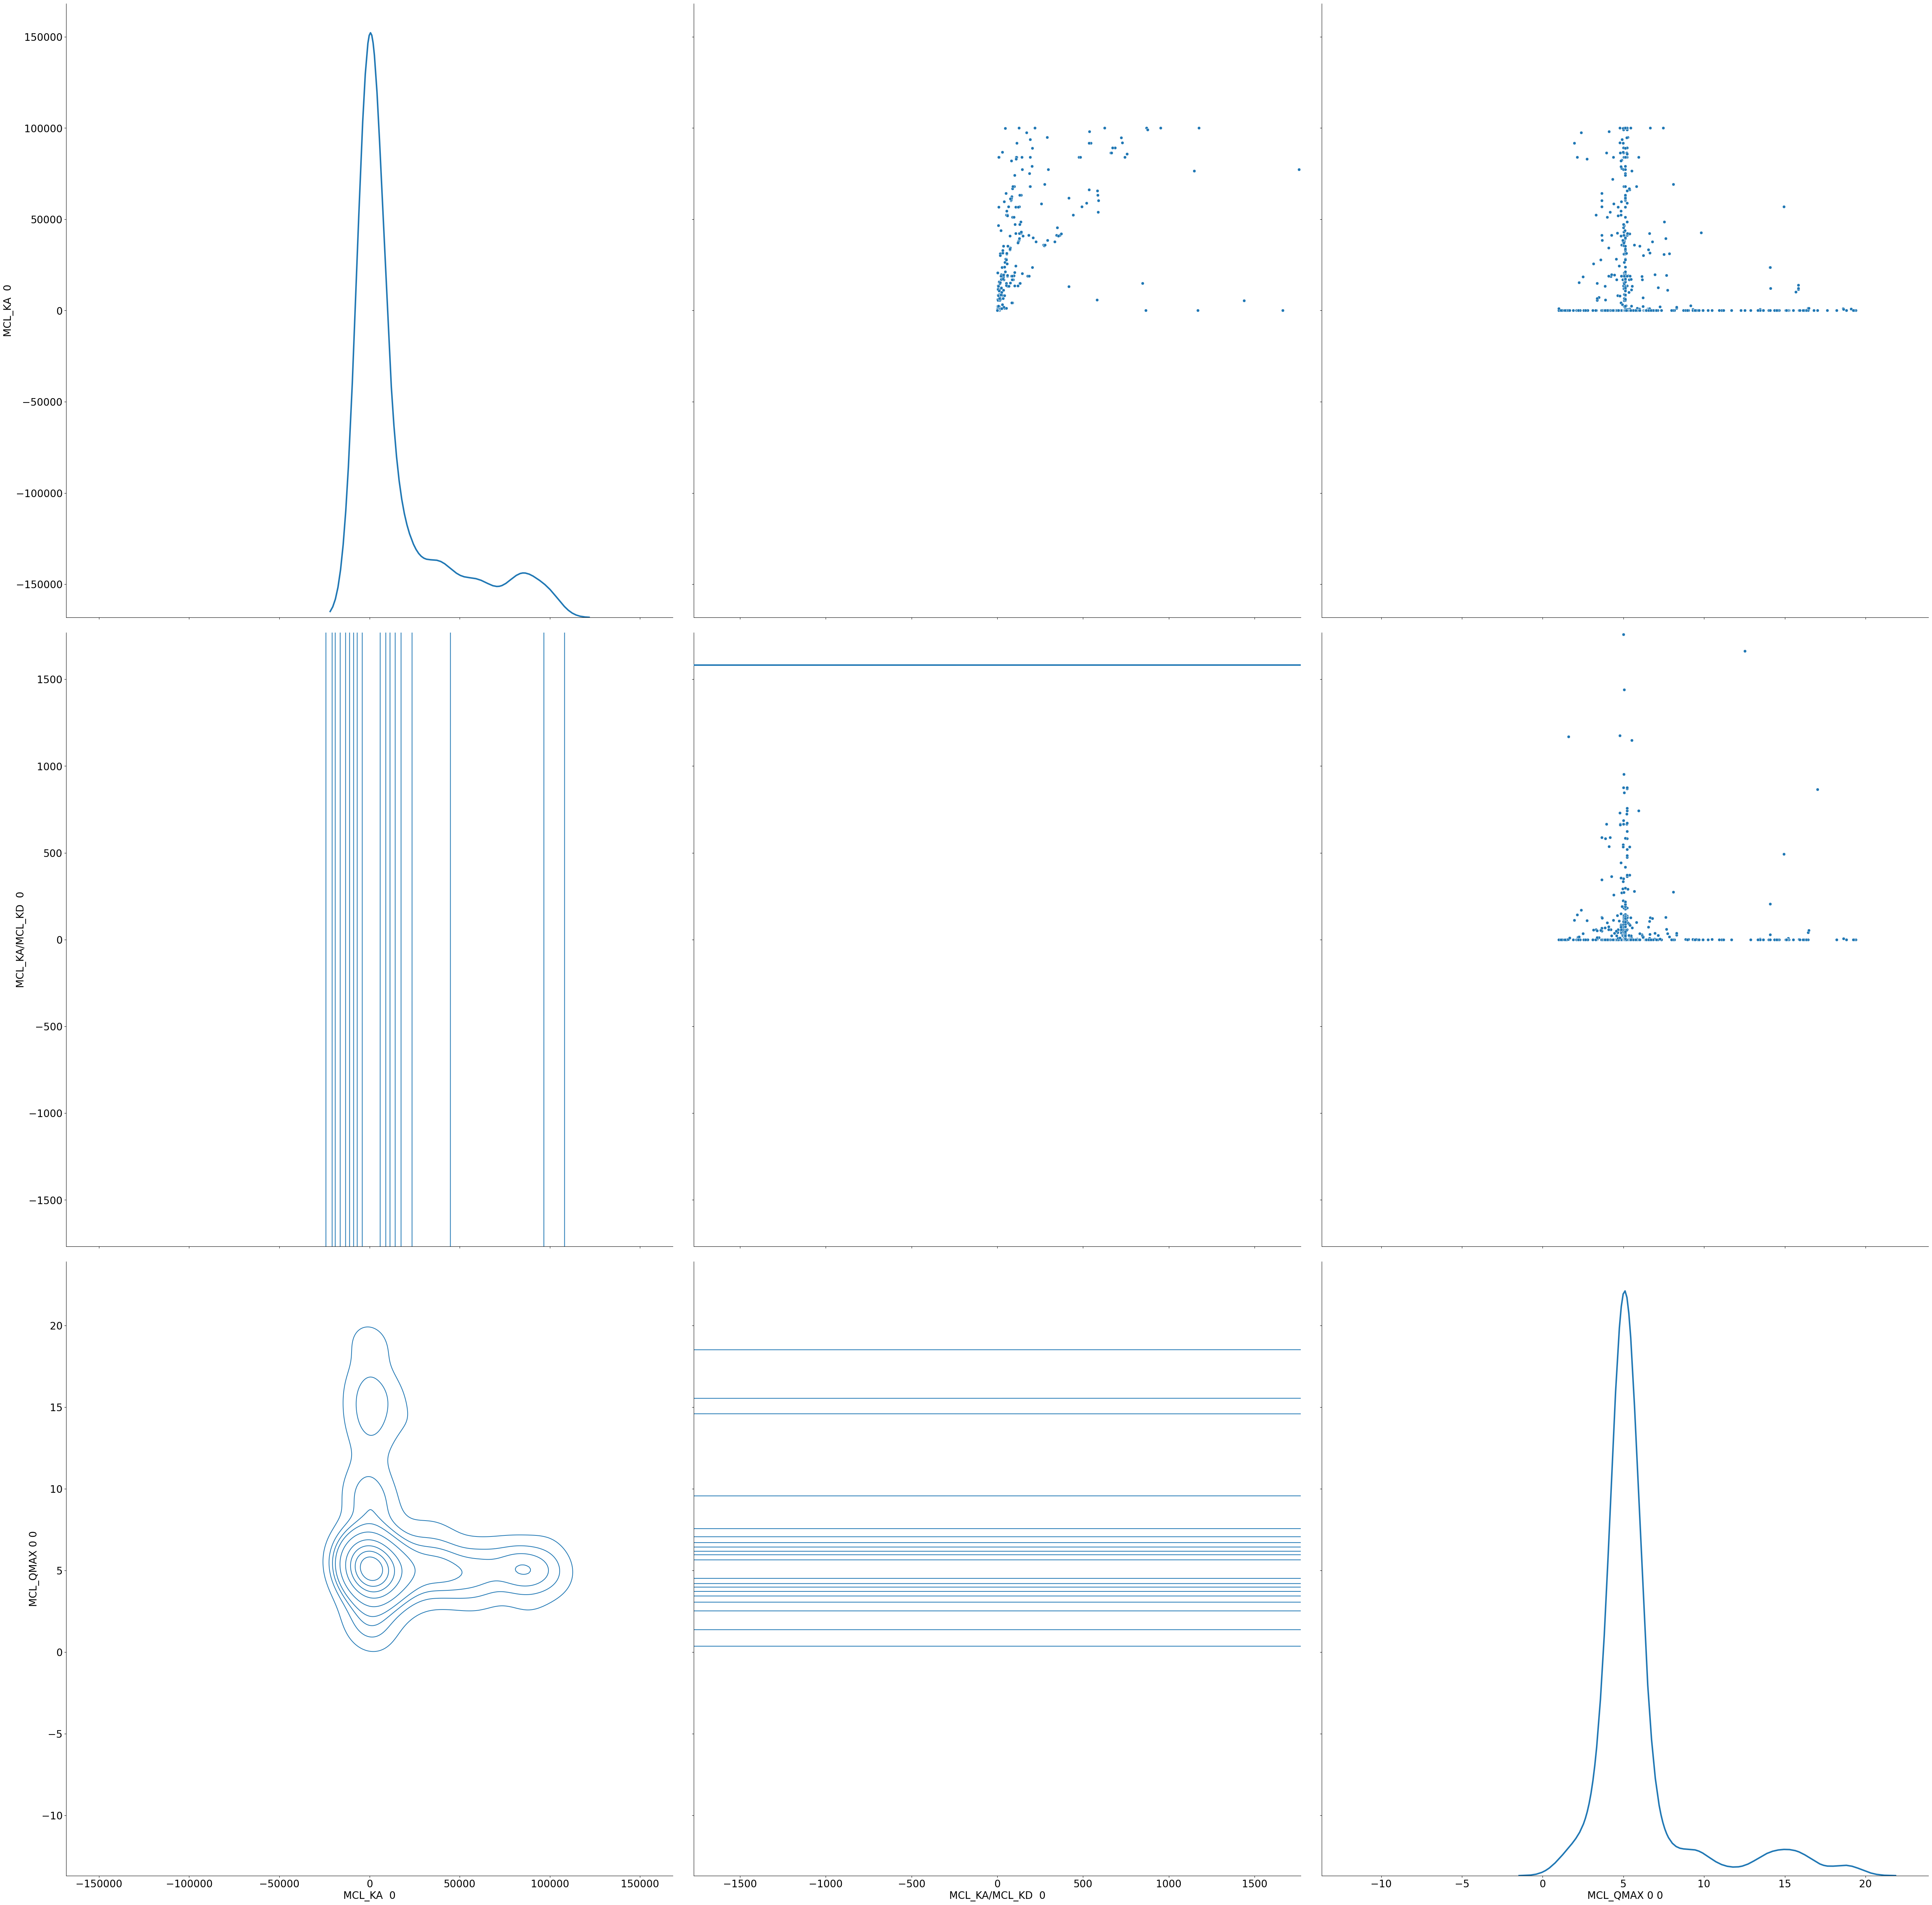

In [10]:
match.plot_corner()

Best item 6ffb222cd13e189afa0cfa34026a0ddf for meta score(s) Product Root Score , Min Score , Mean Score , SSE


Time                              Name Method  \
0  Tue Oct 26 12:37:12 2021  6ffb222cd13e189afa0cfa34026a0ddf   GRAD   

   Condition Number  MCL_KA Comp:None Bound:0  MCL_KD Comp:None Bound:0  \
0      1.627185e+07                  100000.0                217.924877   

   MCL_KA/MCL_KD Comp:None Bound:0  MCL_QMAX Comp:0 Bound:0  main_Pulse_SSE  \
0                       458.873725                 5.111472        0.665846   

   Product Root Score  Min Score  Mean Score       SSE      RMSE  
0            0.665846   0.665846    0.665846  0.665846  0.008371

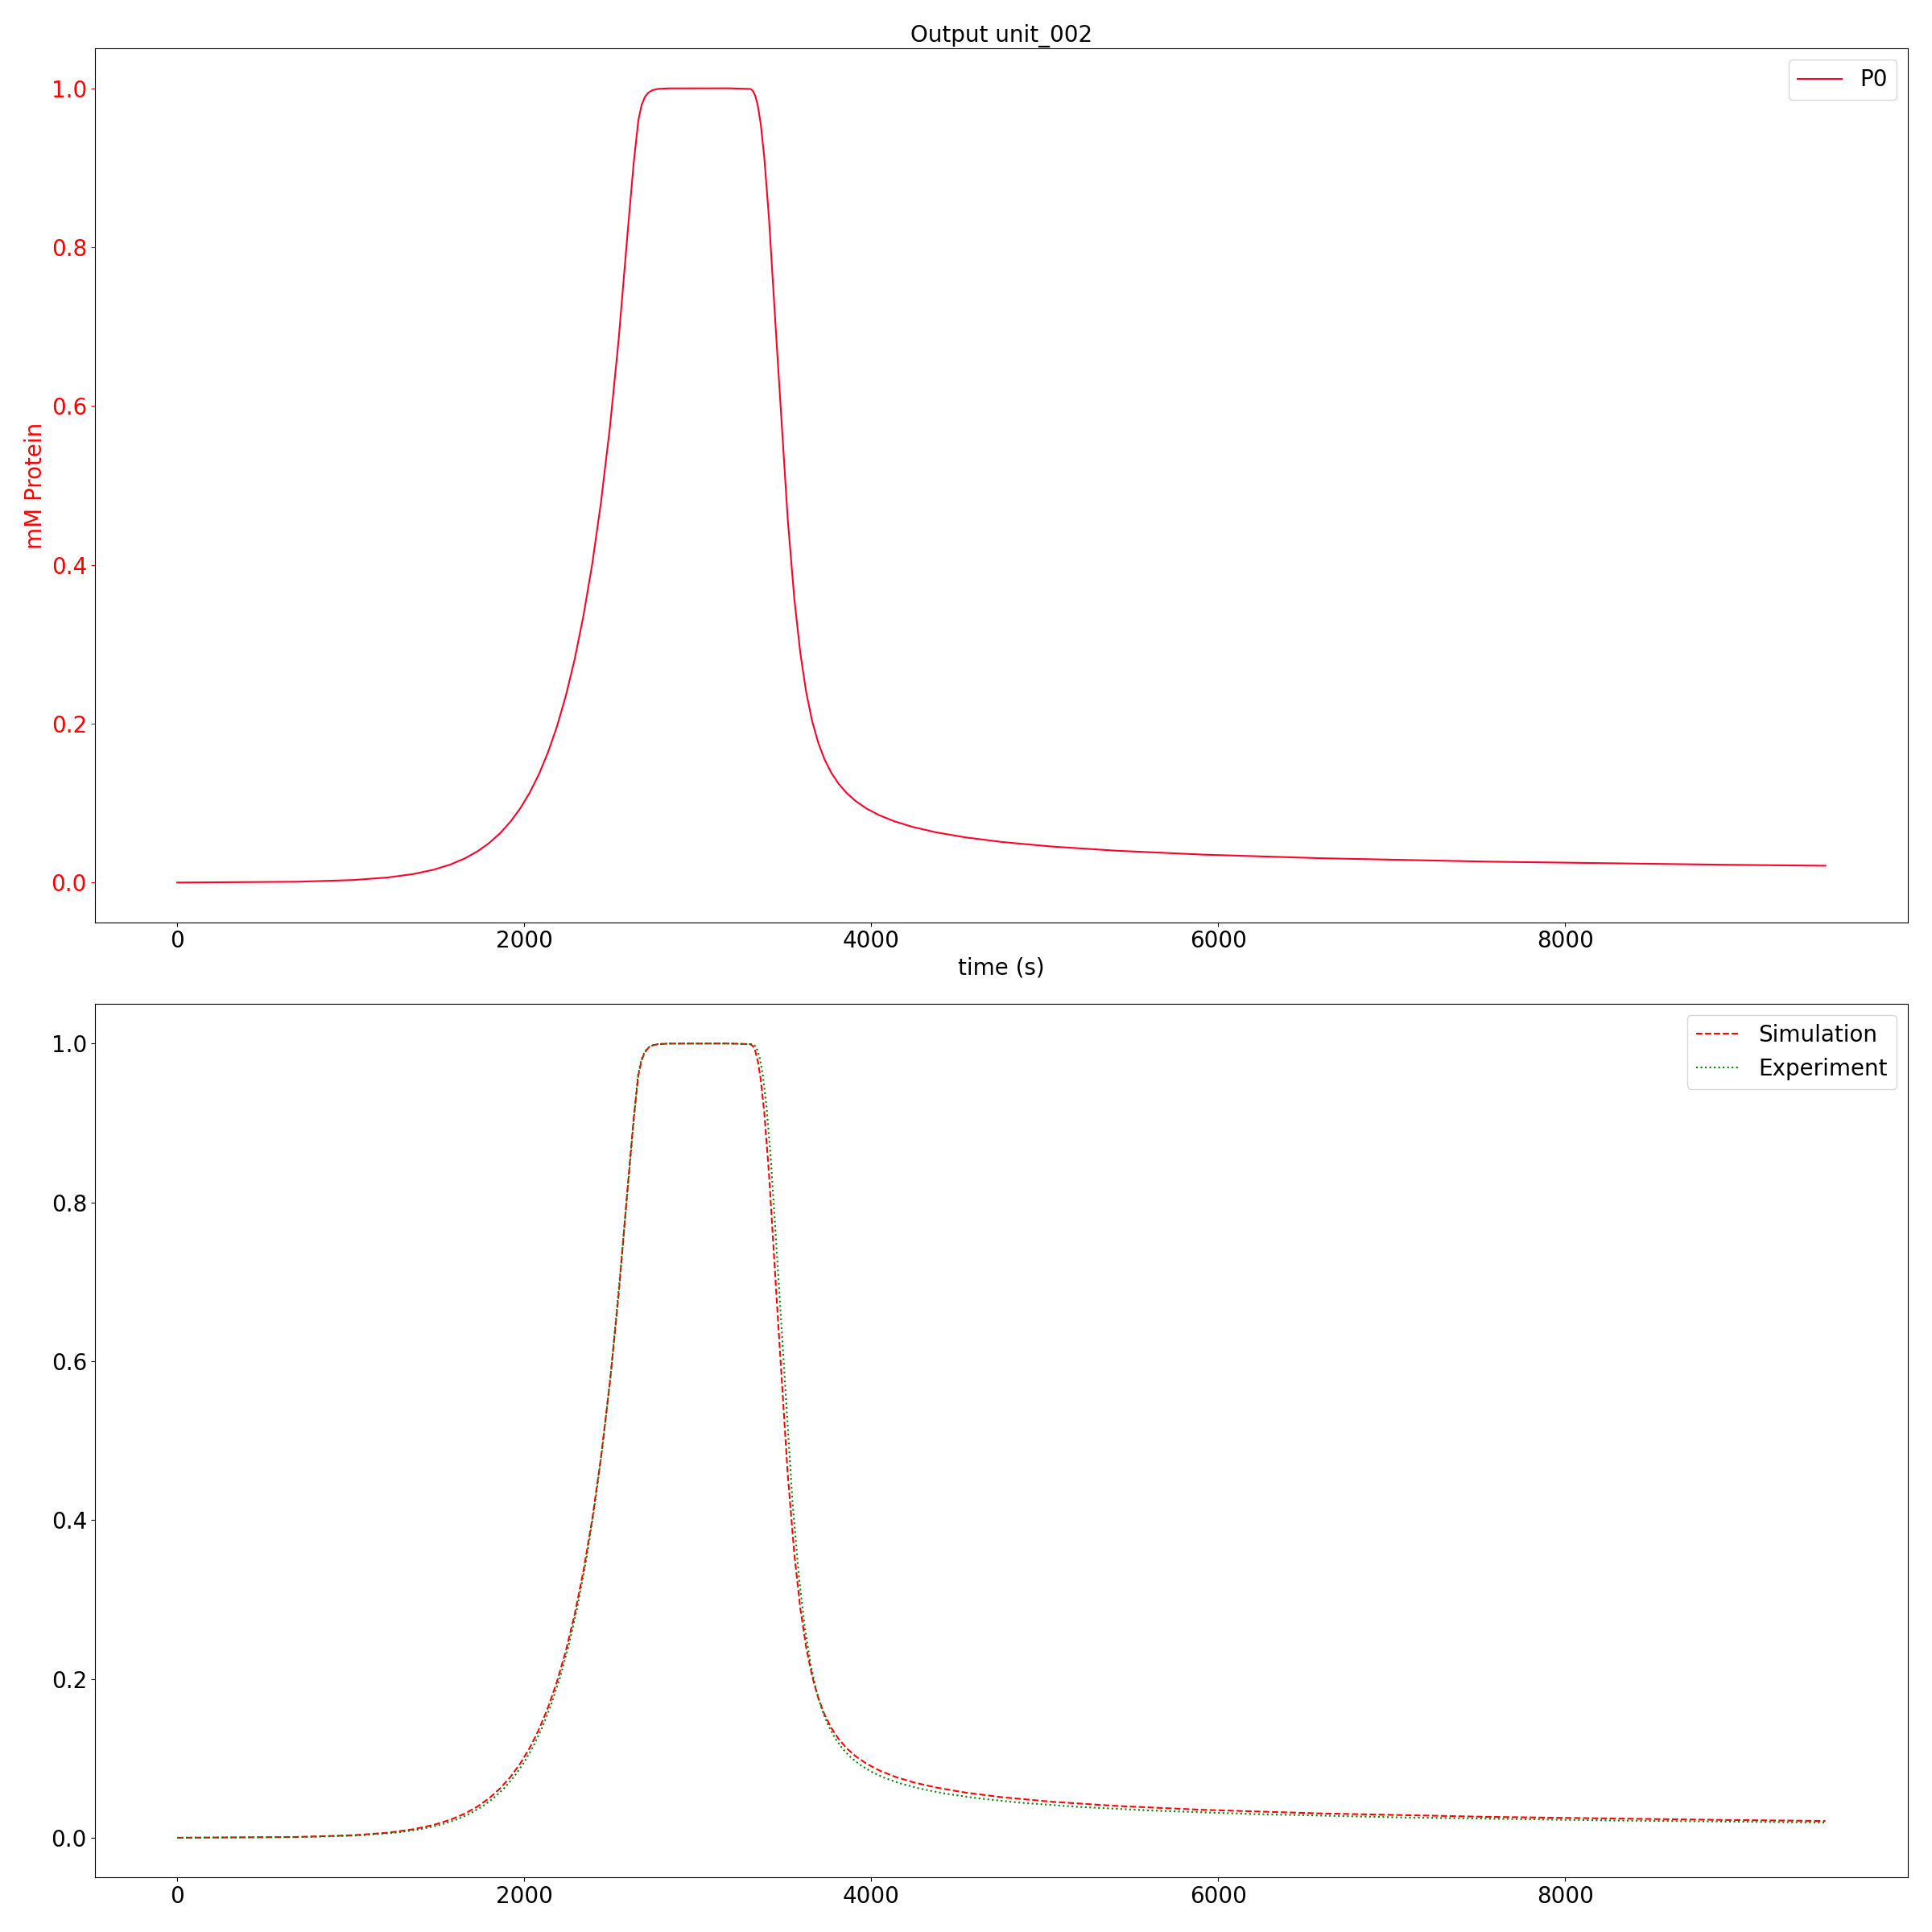

In [11]:
match.plot_best()

## Exercise 3: Shape

Adding to the previous example, now use the `shape` feature type for the pulse instead of `SSE`.

In [12]:
base_dir = Path('./').absolute()
match_config = Dict()
match_config.CADETPath = Cadet.cadet_path
match_config.baseDir = base_dir.as_posix()
match_config.resultsDir = 'results_exercise_keq_shape'

parameter1 = Dict()
parameter1.transform = 'auto_keq'
parameter1.component = 0
parameter1.bound = 0
parameter1.location = ['/input/model/unit_001/adsorption/MCL_KA', '/input/model/unit_001/adsorption/MCL_KD']
parameter1.minKA = 1e-5
parameter1.maxKA = 1e5
parameter1.minKEQ = 1e-4
parameter1.maxKEQ = 1e4

parameter2 = Dict()
parameter2.transform = 'auto'
parameter2.component = 0
parameter2.bound = 0
parameter2.location = '/input/model/unit_001/adsorption/MCL_QMAX'
parameter2.min = 1
parameter2.max = 20

match_config.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = 'resources/langmuir_experiment.csv'
experiment1.output_path = '/output/solution/unit_002/SOLUTION_OUTLET_COMP_000'
experiment1.HDF5 = 'langmuir_reference.h5'
experiment1.name = 'main'

feature1 = Dict()
feature1.name = 'Pulse'
feature1.type = 'Shape'

experiment1.features = [feature1,]

match_config.experiments = [experiment1,]

match_config.searchMethod = 'NSGA3'
match_config.population = 12
match_config.stallGenerations = 10
match_config.finalGradRefinement = True
match_config.gradVector = True

In [13]:
from CADETMatch.jupyter import Match

match_file = base_dir / 'langmuir_keq_shape.json'

with open(match_file, 'w') as json_file:
    json.dump(match_config.to_dict(), json_file, indent='\t')

match = Match(match_file)
match.start_sim()

/home/jo/software/miniconda3/envs/chromapy/lib/python3.9/subprocess.py:941: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


2021-10-26 12:38:08,277 match.py print_version 121 CADETMatch starting up version: 0.8.13

2021-10-26 12:38:08,290 match.py print_version 150 attrs version: 21.2.0 tested with 21.2.0

2021-10-26 12:38:08,291 match.py print_version 150 joblib version: 1.1.0 tested with 1.0.1

2021-10-26 12:38:08,291 match.py print_version 150 addict version: 2.4.0 tested with 2.4.0

2021-10-26 12:38:08,292 match.py print_version 150 corner version: 2.2.1 tested with 2.2.1

2021-10-26 12:38:08,292 match.py print_version 150 emcee version: 3.1.1 tested with 3.0.2

2021-10-26 12:38:08,293 match.py print_version 150 SALib version: 1.4.5 tested with 1.3.11

2021-10-26 12:38:08,294 match.py print_version 150 psutil version: 5.8.0 tested with 5.8.0

2021-10-26 12:38:08,295 match.py print_version 150 numpy version: 1.20.3 tested with 1.21.1

2021-10-26 12:38:08,295 match.py print_version 150 openpyxl version: 3.0.9 tested with 3.0.7

2021-10-26 12:38:08,296 match.py print_version 150 scipy version: 1.7.1 tested

Corner plot in search space


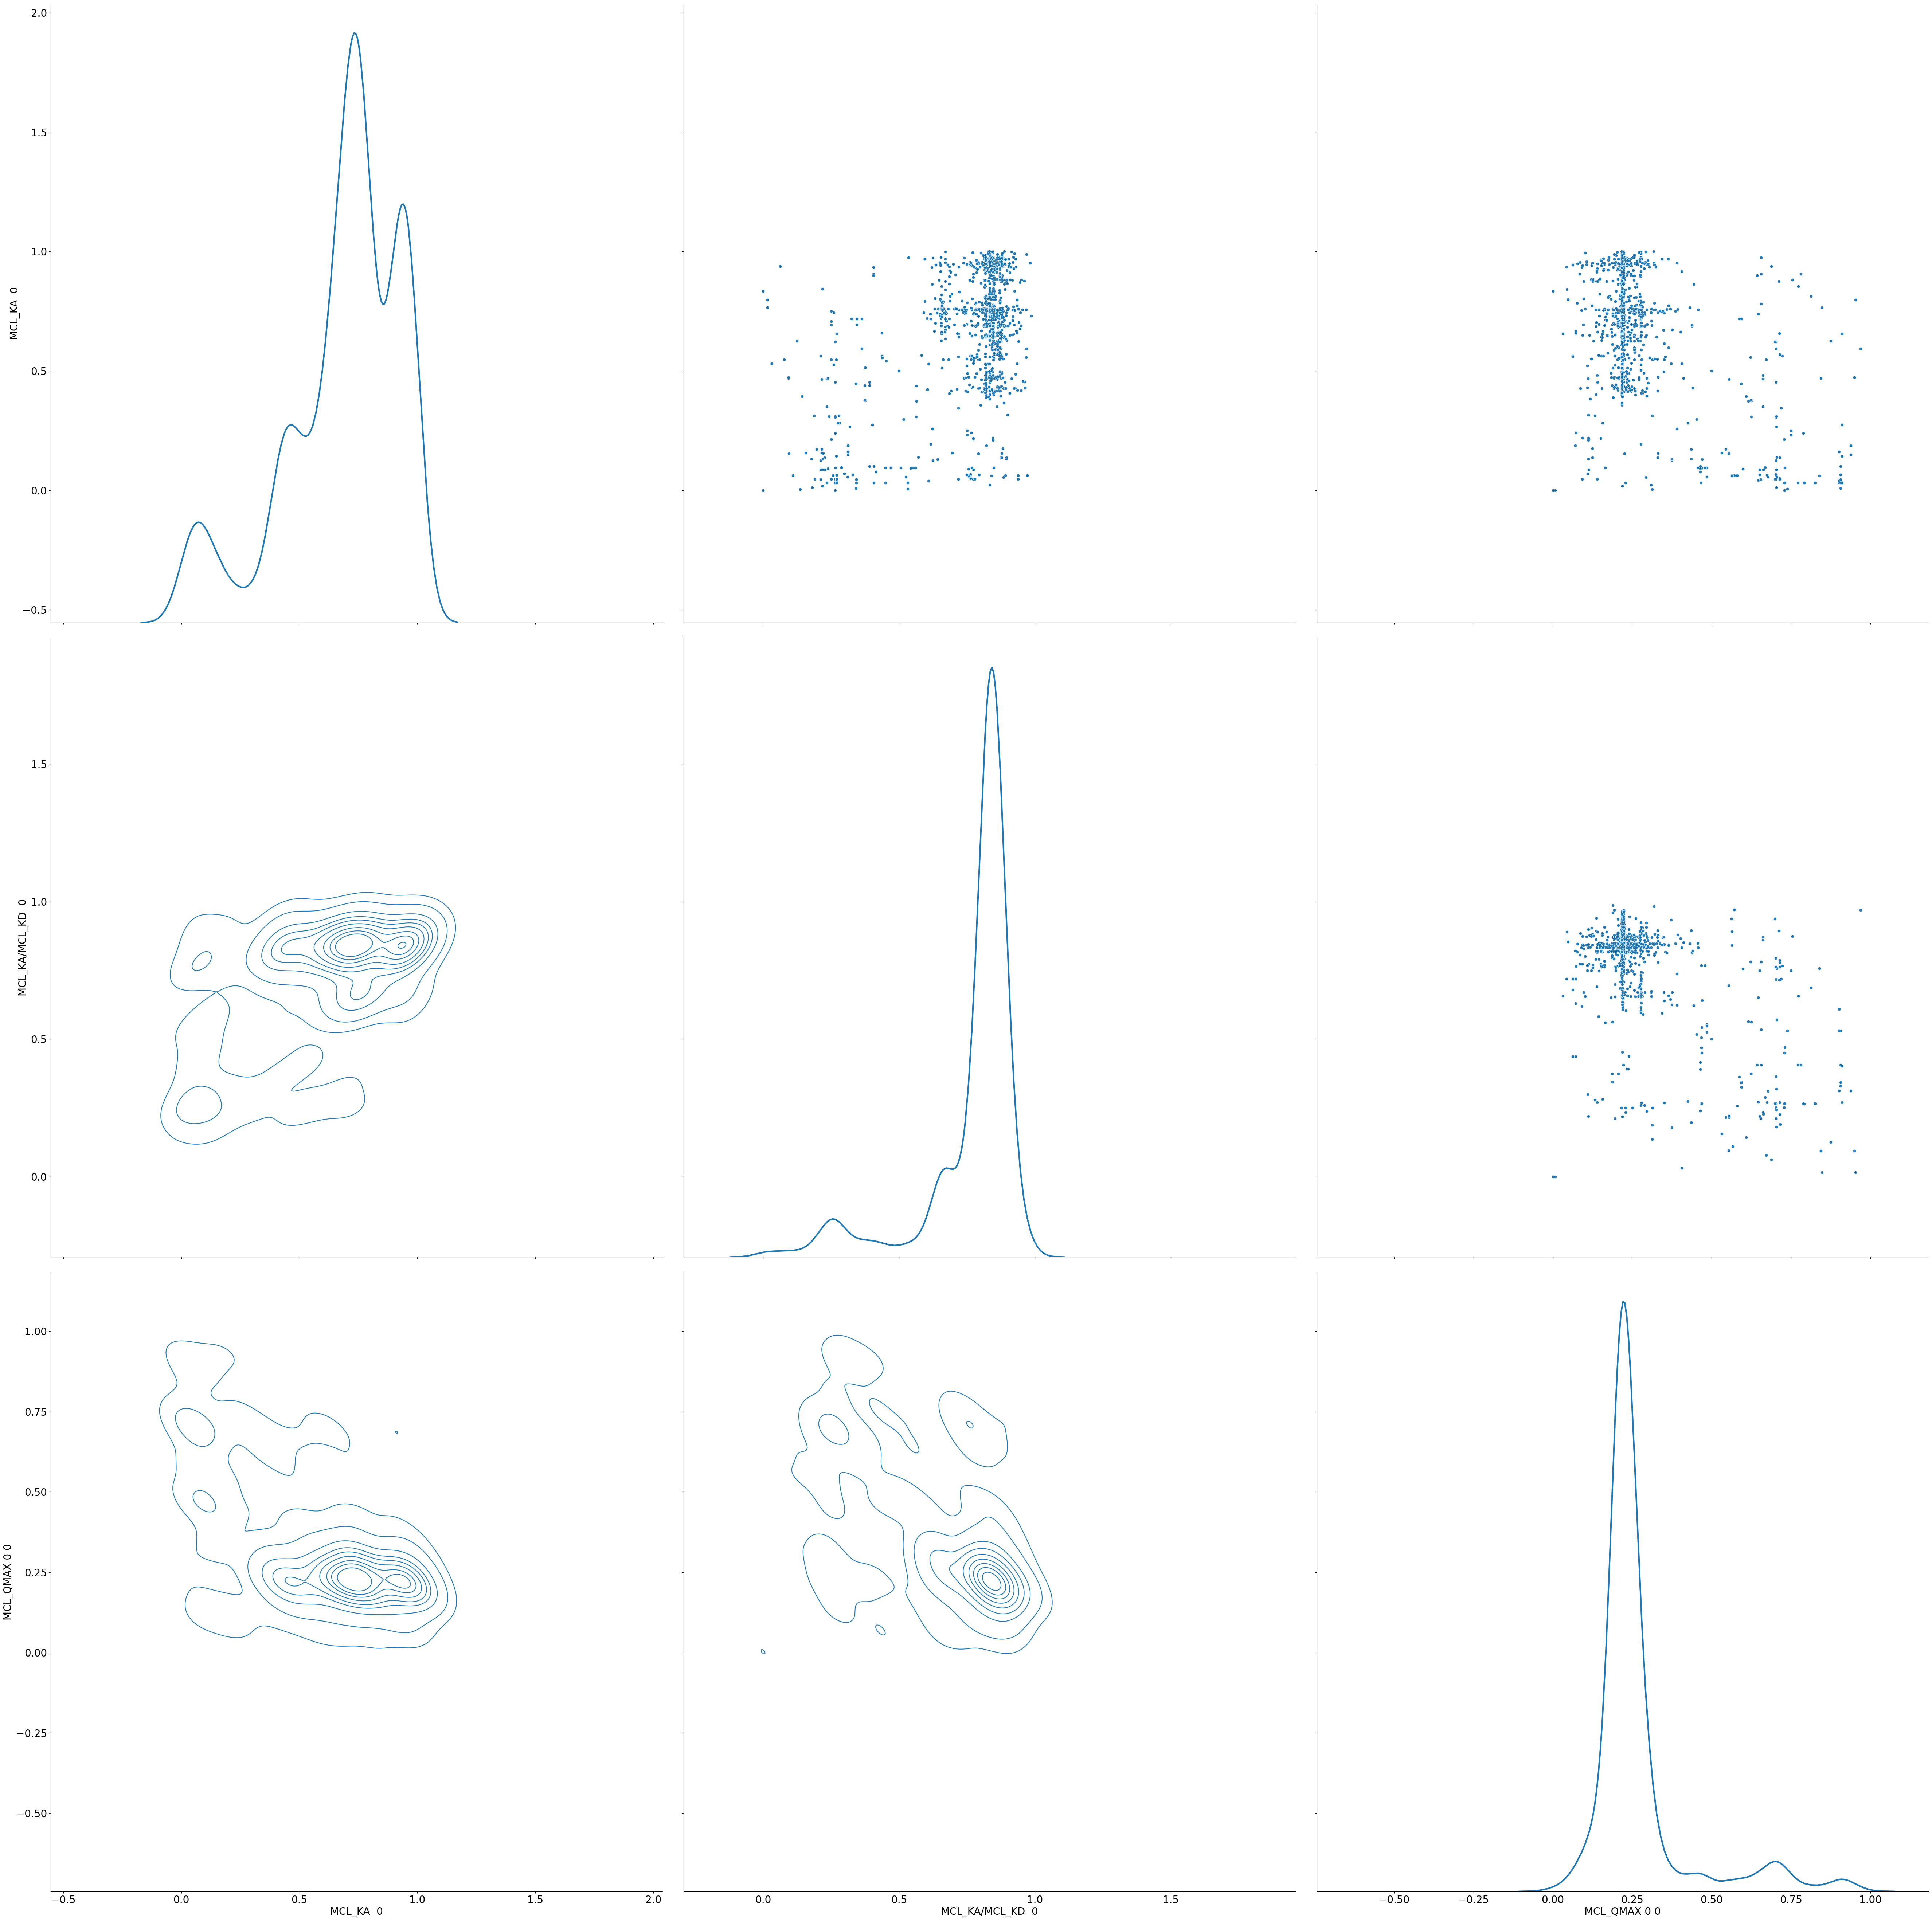

Corner plot in original space


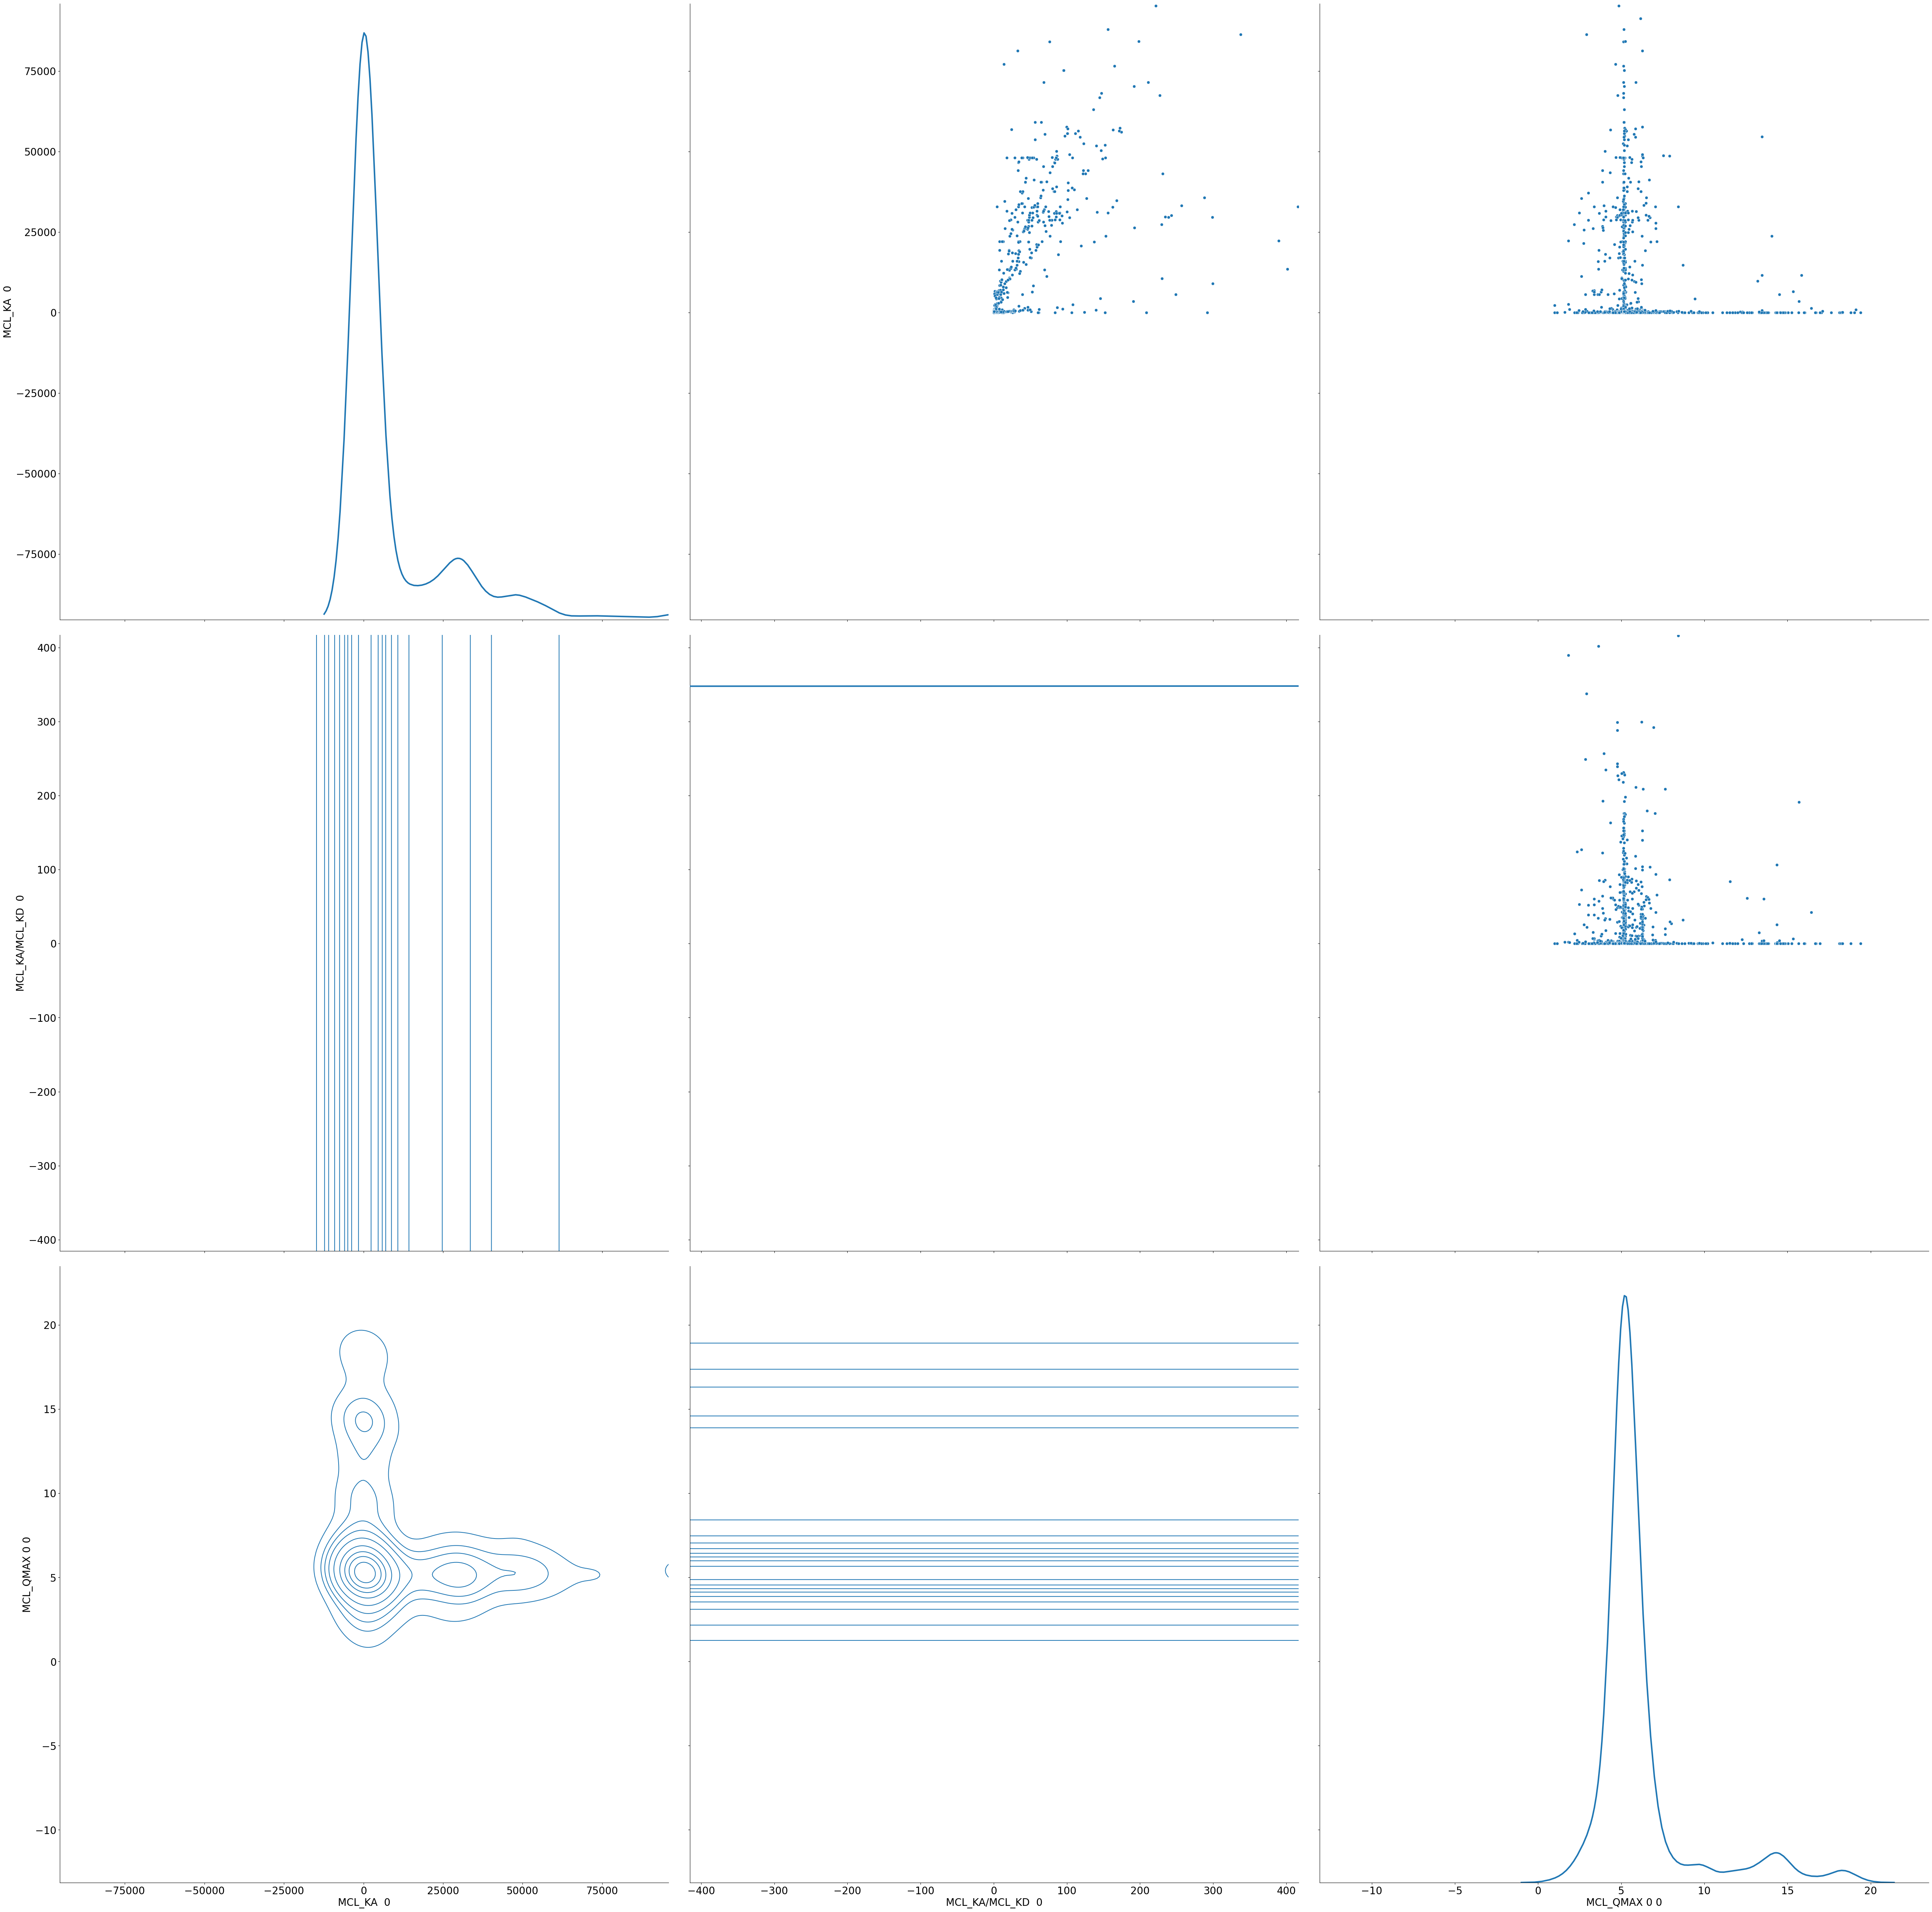

In [14]:
match.plot_corner()

Best item 4a5287b3c0cde7405b5e3fad1bca6518 for meta score(s) Product Root Score , Mean Score


Time                              Name Method  \
1  Tue Oct 26 12:58:04 2021  4a5287b3c0cde7405b5e3fad1bca6518    EVO   

   Condition Number  MCL_KA Comp:None Bound:0  MCL_KD Comp:None Bound:0  \
1               NaN                 365.22637                  0.761572   

   MCL_KA/MCL_KD Comp:None Bound:0  MCL_QMAX Comp:0 Bound:0  \
1                       479.568801                 5.151249   

   main_Pulse_Similarity  main_Pulse_Value  main_Pulse_Time  \
1               0.000501           0.00022         0.009232   

   main_Pulse_Derivative_Similarity  main_Pulse_Der_High_Value  \
1                           0.01047                   0.011322   

   main_Pulse_Der_Low_Value  Product Root Score  Min Score  Mean Score  \
1                  0.001325            0.005524   0.011322    0.005512   

        SSE      RMSE  
1  1.045193  0.010489

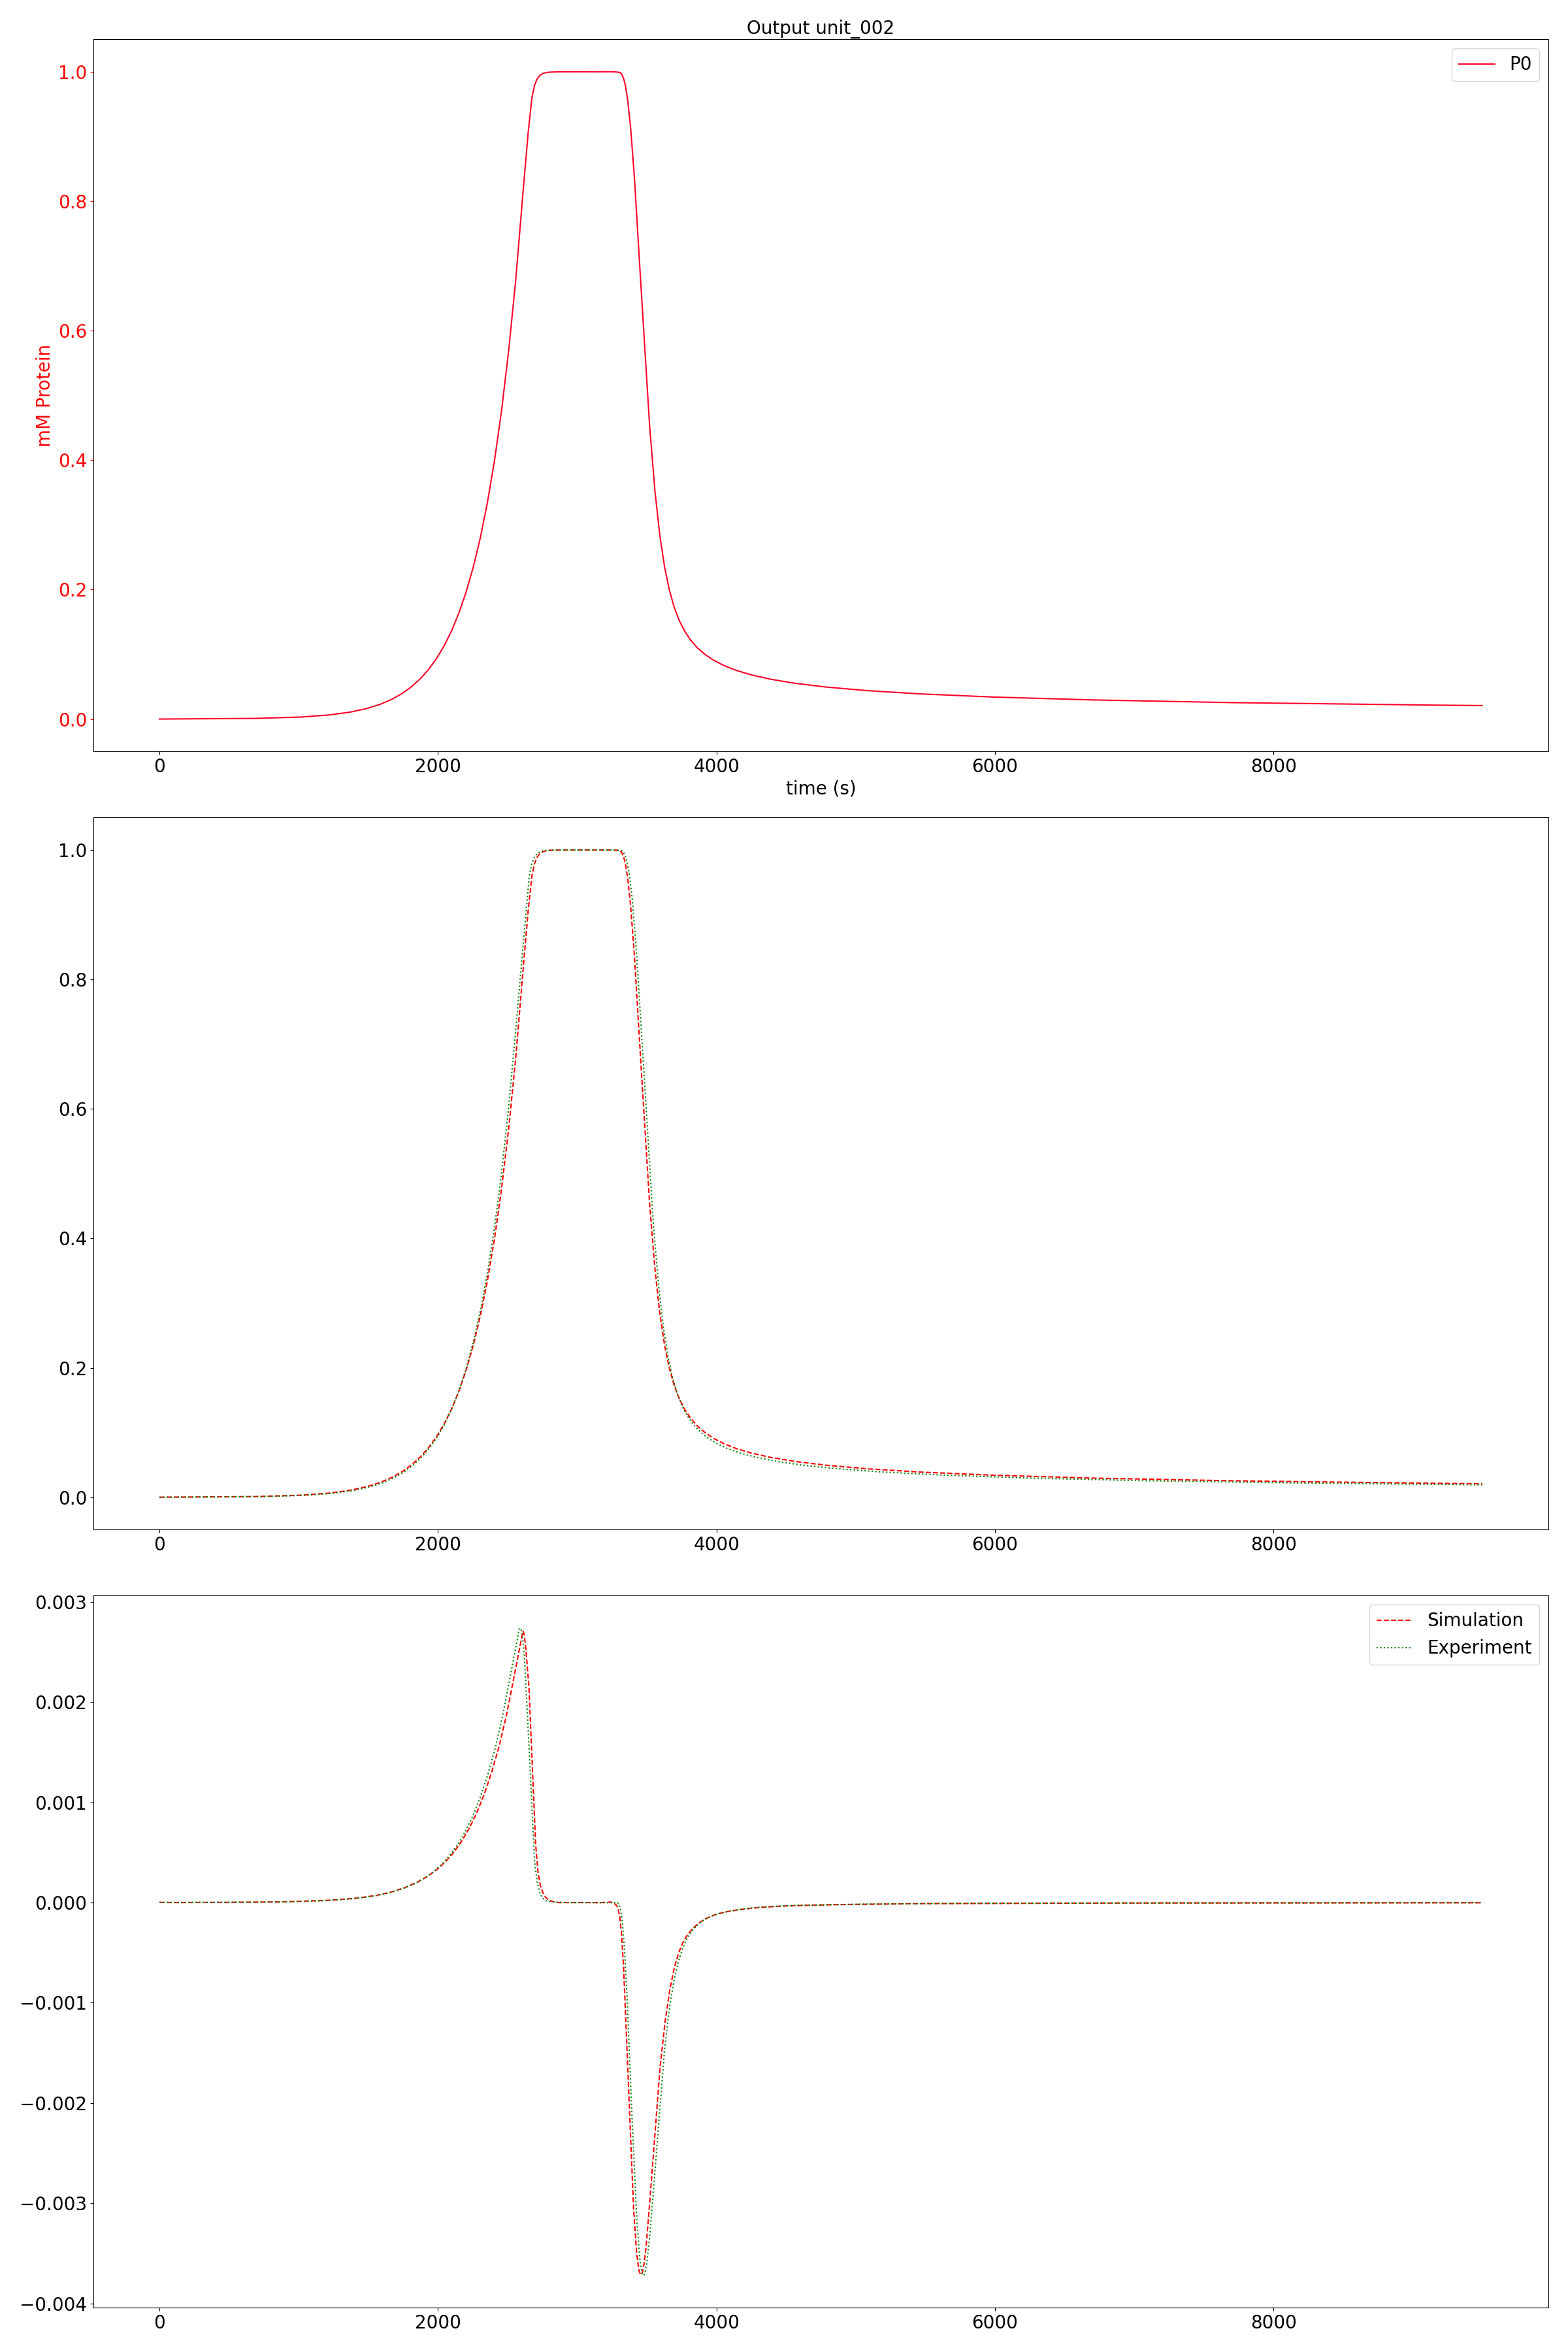

Best item 3b826c2edbce7c3d9e9171282b43146d for meta score(s) Min Score , SSE


Time                              Name Method  \
0  Tue Oct 26 13:05:42 2021  3b826c2edbce7c3d9e9171282b43146d    EVO   

   Condition Number  MCL_KA Comp:None Bound:0  MCL_KD Comp:None Bound:0  \
0               NaN                341.848977                  0.639948   

   MCL_KA/MCL_KD Comp:None Bound:0  MCL_QMAX Comp:0 Bound:0  \
0                       534.182053                 5.172198   

   main_Pulse_Similarity  main_Pulse_Value  main_Pulse_Time  \
0               0.000778          0.000116     1.211915e-12   

   main_Pulse_Derivative_Similarity  main_Pulse_Der_High_Value  \
0                          0.015115                    0.00358   

   main_Pulse_Der_Low_Value  Product Root Score  Min Score  Mean Score  \
0                  0.010391            0.005013   0.015115    0.004996   

        SSE      RMSE  
0  1.617125  0.013046

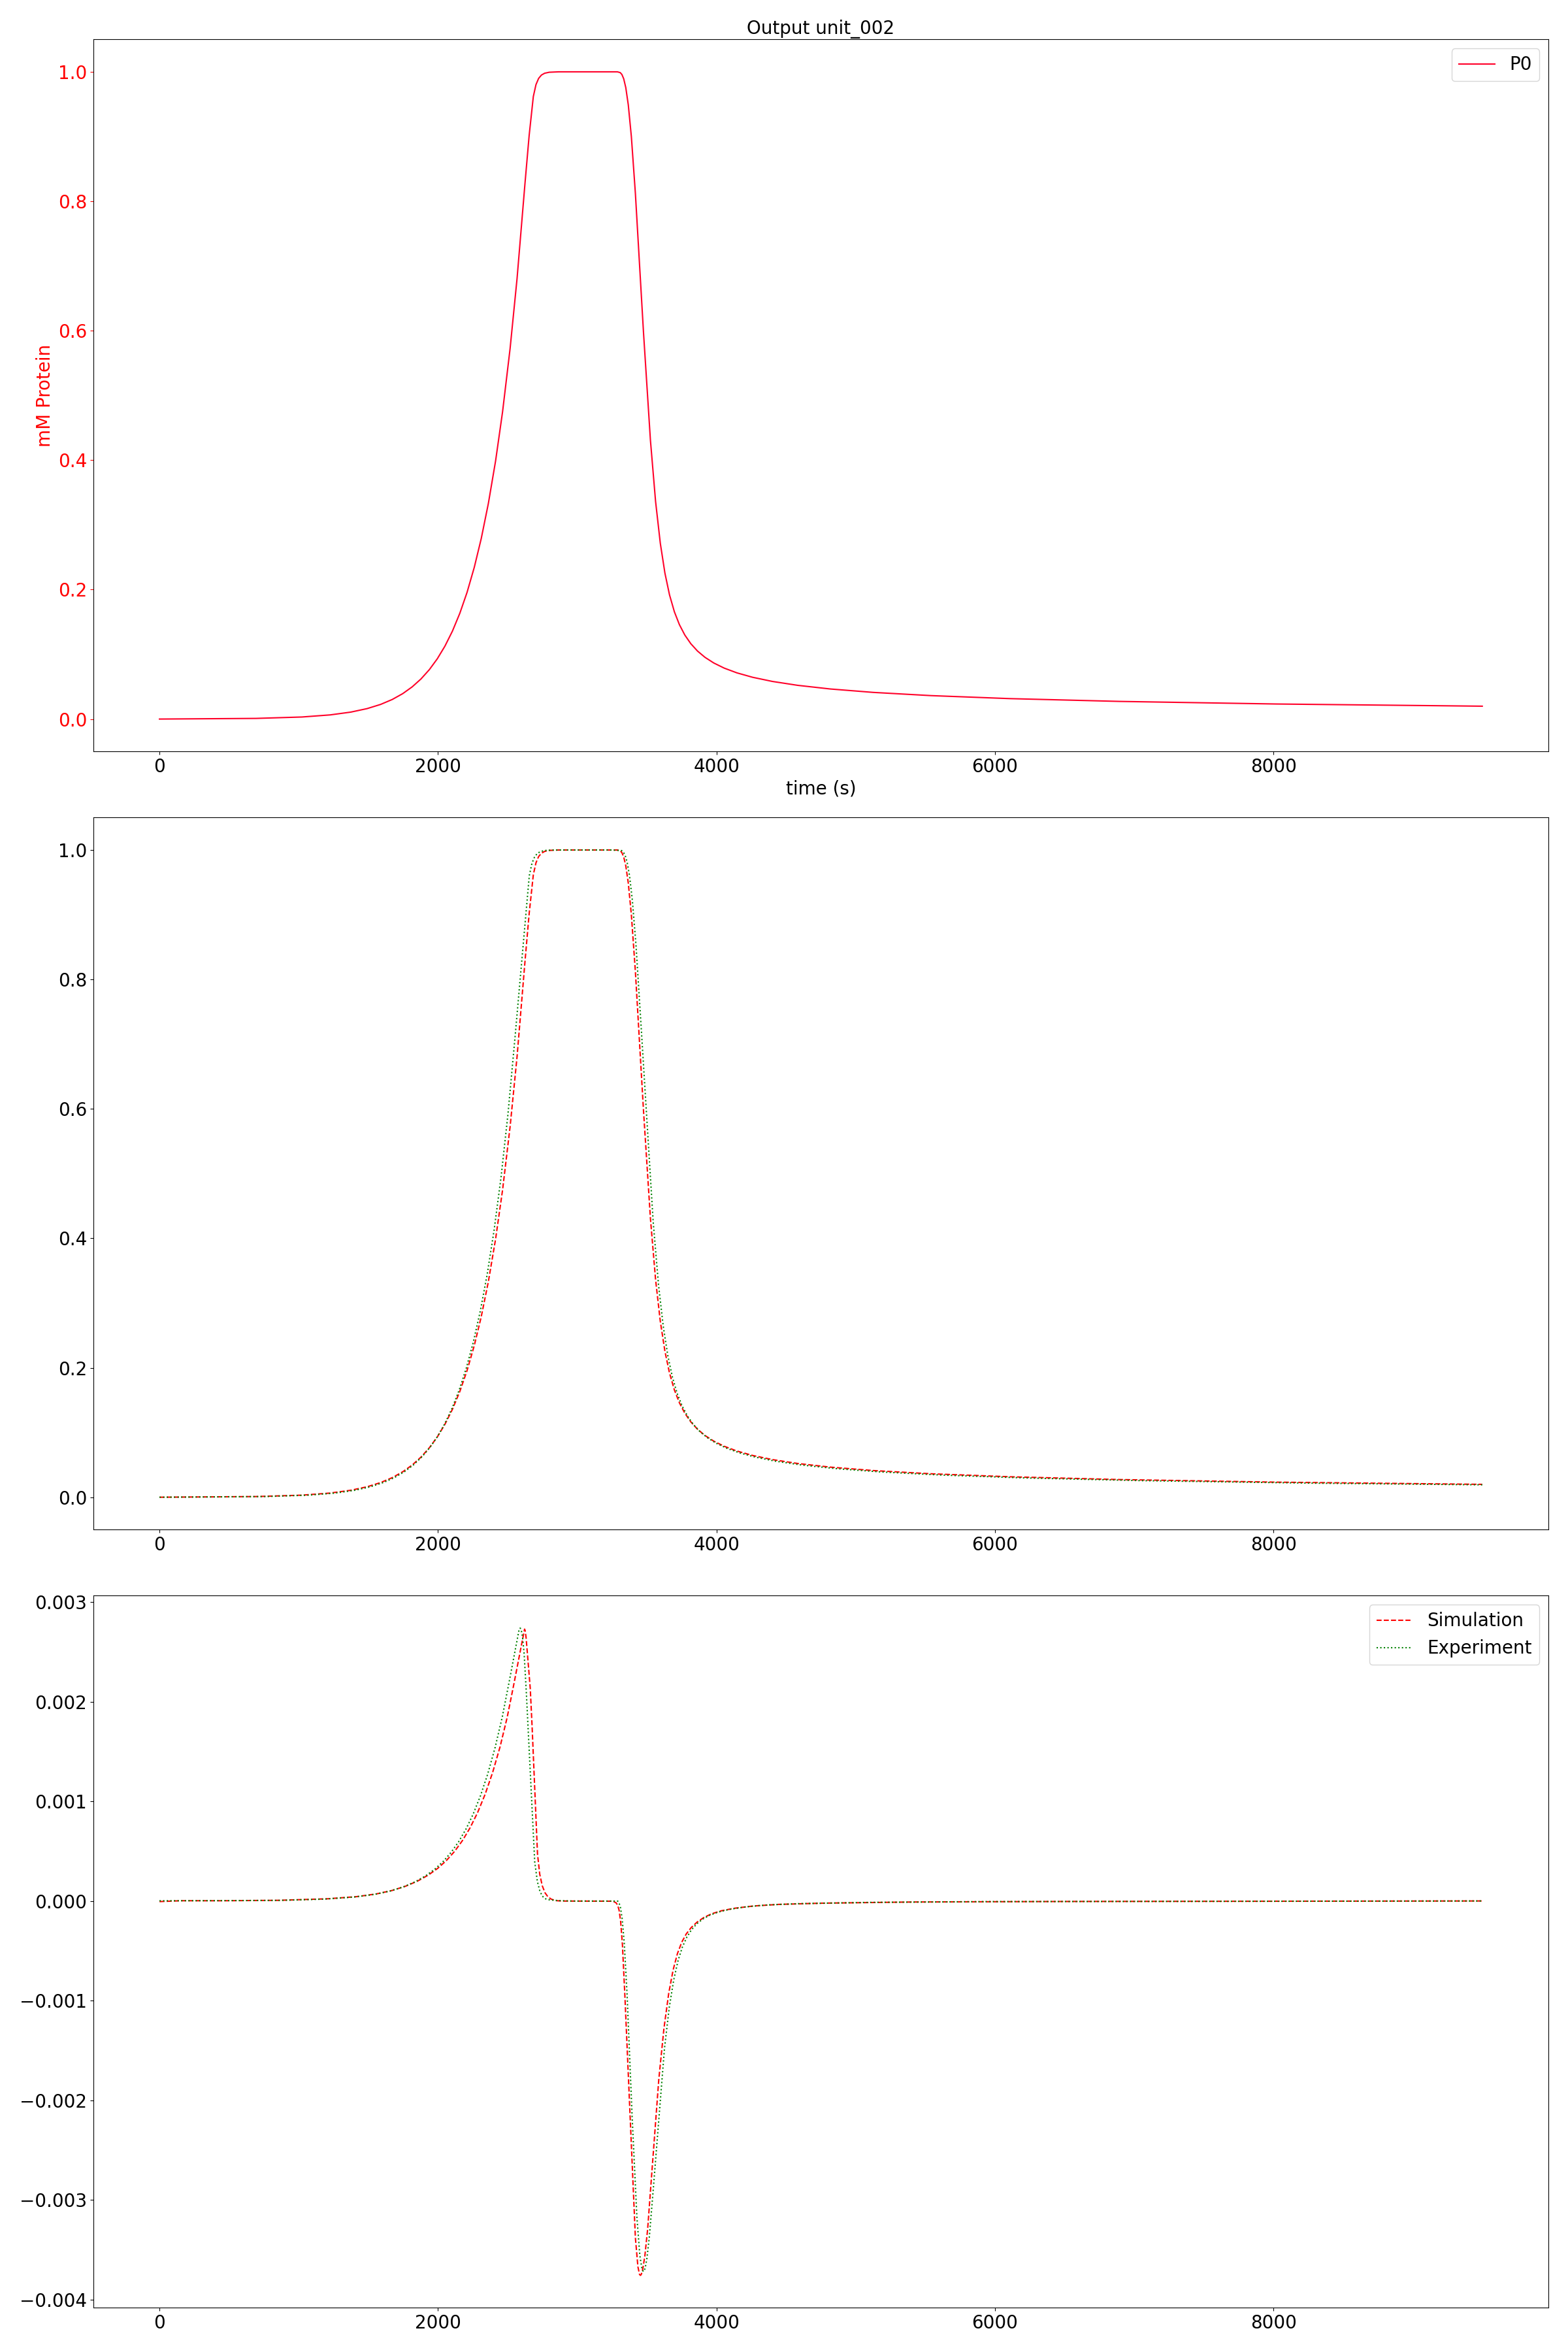

In [15]:
match.plot_best()